In [2]:
# system tools
import warnings
import json
import sys
import string
import ast

# data cleaning + analysis tools
import pandas as pd
import datetime as dt
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

#nltk tools
import spacy
import lda #Latent Dirichlet Allocation (create topics)
import gensim
from gensim import corpora, models #for constructing document term matrix
#from stop_words import get_stop_words
from gensim.models import Phrases
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams

#set notebook preferences
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


### Import JSON file with city metadata - including which cities have sufficient Public Record Request (PRR) data for analysis

In [47]:
json_file = '../data/cities.json'

with open(json_file, 'r') as f:
    md = json.load(f)

###  Create dataframe of PRR data for all relevant cities

In [96]:
data_raw = pd.DataFrame(columns = ['city', 'month_year', 'Summary'])
city_list = []
for key, value in md.items():
    city = value['name']
    filepath = '/Users/alenastern/Google Drive File Stream/My Drive/Alena_Project/PR_Data/{}.csv'.format(city)
    if value["desc"] == "Y":
        try:
            df = pd.read_csv(filepath)
        except:
            try:
                df = pd.read_csv(filepath, encoding='mac_roman')
            except:
                continue
        print(key)
        name = key.split(' ')
        # remove lower for new version
        city_list.extend([x for x in name[:-1]])
    else:
        continue
    
    try:
        df['Create Date'] = pd.to_datetime(df['Create Date'])
    except:
        df['New'] = pd.to_datetime(df['Create Date'].apply(lambda x: re.findall('^\S*', x)[0]))
        df.drop(columns=['Create Date'], inplace = True)
        df.rename(index=str, columns={"New": "Create Date"}, inplace = True)

    df['month_year'] = df['Create Date'].dt.to_period('M')
    
    mc = df[['month_year', 'Summary']]
    mc['city'] = city
    
    data_raw = pd.concat([data_raw, mc])
    
print(city_list)

Arlington city
Asheville city
Bainbridge Island city
Boulder County
Cathedral City city
Clearwater city
Dayton city
Denton city
Everett city
Fort Collins city
Greensboro city
Hayward city
Kirkland city
Las Cruces city
Lynnwood city
Mercer Island city
Miami city
Middleborough town
New Orleans city
Oakland city
Oklahoma City city
Olympia city
Palo Alto city
Peoria city
Pullman city
Rancho Cucamonga city
Redmond city
Renton city
Sacramento city
San Francisco city
Tukwila city
Vallejo city
West Sacramento city
Winchester city
['Arlington', 'Asheville', 'Bainbridge', 'Island', 'Boulder', 'Cathedral', 'City', 'Clearwater', 'Dayton', 'Denton', 'Everett', 'Fort', 'Collins', 'Greensboro', 'Hayward', 'Kirkland', 'Las', 'Cruces', 'Lynnwood', 'Mercer', 'Island', 'Miami', 'Middleborough', 'New', 'Orleans', 'Oakland', 'Oklahoma', 'City', 'Olympia', 'Palo', 'Alto', 'Peoria', 'Pullman', 'Rancho', 'Cucamonga', 'Redmond', 'Renton', 'Sacramento', 'San', 'Francisco', 'Tukwila', 'Vallejo', 'West', 'Sacrame

#### We can see the raw data below. Our raw dataset includes 86,416 PRRs from 33 different cities

In [153]:
data_raw.to_csv('data_raw.csv')

In [126]:
data_raw = pd.read_csv('data_raw.csv')

In [89]:
data_raw.head()

,Summary,city,month_year
0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06
1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06
2,"Copies of Building Permits of $5,000 valuation and up ($20,000 min for Re-Roofs), ($50,000 min. for Cell Tower upgrades), (Electrical, Mechanical & Plumbing at $100,000 min.) and (Solar Panels, Swimming Pools & Foundations at any valuation)",Arlington,2018-06
3,"police report filed to an officer against Wayne Parris (DOB 08-03-1957) from Brittany J. Parris. The paperwork I have has a case number D18-39 it is also stamped at the bottom with 18-1294, Iím not sure which number you will need. If there is any other information needed please let me know.",Arlington,2018-06
4,"Email Communications between Stephanie Shook, Dave Kraski, Bruce Stedman and Chad Schmidt in regards to Fire Protection District 21 billing and passage of contract for ALS Services. \n\nAlso any copies of Agenda Bills, D21 Contract and materials presented for review in Nov/Dec time frame in regards to the contract.",Arlington,2018-06


In [49]:
data_raw.shape

(110138, 3)

In [91]:
len(data_raw.city.unique())

34

In [50]:
data_raw.index = pd.RangeIndex(len(data_raw.index))
data_raw.reset_index(inplace=True)

### Create dataframe for cleaning by removing null summaries

In [51]:
data = data_raw.dropna(subset=['Summary'])

In [22]:
data.head()

,index,Summary,city,month_year
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06
2,2,"Copies of Building Permits of $5,000 valuation and up ($20,000 min for Re-Roofs), ($50,000 min. for Cell Tower upgrades), (Electrical, Mechanical & Plumbing at $100,000 min.) and (Solar Panels, Swimming Pools & Foundations at any valuation)",Arlington,2018-06
3,3,"police report filed to an officer against Wayne Parris (DOB 08-03-1957) from Brittany J. Parris. The paperwork I have has a case number D18-39 it is also stamped at the bottom with 18-1294, Iím not sure which number you will need. If there is any other information needed please let me know.",Arlington,2018-06
4,4,"Email Communications between Stephanie Shook, Dave Kraski, Bruce Stedman and Chad Schmidt in regards to Fire Protection District 21 billing and passage of contract for ALS Services. \n\nAlso any copies of Agenda Bills, D21 Contract and materials presented for review in Nov/Dec time frame in regards to the contract.",Arlington,2018-06


In [95]:
city_list

['arlington',
 'asheville',
 'bainbridge',
 'island',
 'boulder',
 'cathedral',
 'city',
 'clearwater',
 'dayton',
 'denton',
 'everett',
 'fort',
 'collins',
 'greensboro',
 'hayward',
 'kirkland',
 'las',
 'cruces',
 'lynnwood',
 'mercer',
 'island',
 'miami',
 'middleborough',
 'new',
 'orleans',
 'oakland',
 'oklahoma',
 'city',
 'olympia',
 'palo',
 'alto',
 'peoria',
 'pullman',
 'rancho',
 'cucamonga',
 'redmond',
 'renton',
 'sacramento',
 'san',
 'francisco',
 'tukwila',
 'vallejo',
 'west',
 'sacramento',
 'winchester']

#### Function to convert nltk part of speech tags to wordnet tags (we use this to stem the words in data cleaning below):

In [52]:
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

## Clean PRR data to prepare for LDA analysis

In [31]:
# Replace common acronyms in Summary
data.Summary = data.Summary.str.replace('NOPD', 'police department')
data.Summary = data.Summary.str.replace('OPD' , 'police department')
data.Summary = data.Summary.str.replace('SFPD', 'police department')
data.Summary = data.Summary.str.replace('CPD', 'police department')
data.Summary = data.Summary.str.replace('APD', 'police department')
data.Summary = data.Summary.str.replace('GPD', 'police department')
data.Summary = data.Summary.str.replace('KPD', 'police department')

# PDRD = portable digital recording device (body cam) worn by police
data.Summary = data.Summary.str.replace('PDRD', 'police body camera')

# Turn to lowercase
data['sum_ed'] = data.Summary.str.lower()

# Replace key numbers with strings
data.sum_ed = data.sum_ed.str.replace(' 911 ', ' nineoneone ')
data.sum_ed = data.sum_ed.str.replace(' 311 ', ' threeoneone ')
data.sum_ed = data.sum_ed.str.replace(' 9-11 ', ' nineoneone ')
data.sum_ed = data.sum_ed.str.replace(' 3-11 ', ' threeoneone ')

# Replace hyphen and slash with space
hyphen_translator = str.maketrans('-/','  ')
data.sum_ed = data.sum_ed.str.translate(hyphen_translator)

# Remove all punctuation
translator = str.maketrans('','', string.punctuation)
data.sum_ed = data.sum_ed.str.translate(translator)

# Remove all city names
for city in city_list:
    data.sum_ed = data.sum_ed.str.replace(city, '')

# Remove all state names
state_list = ['washington', 'north carolina', 'carolina', 'colorado', 'california',
             'ohio', 'texas', 'new mexico', 'florida', 'massachusetts',
             'louisiana', 'oklahoma', 'arizona', 'rhode island','rhode', 'virginia']

for state in state_list:
     data.sum_ed = data.sum_ed.str.replace(state, '')
            
# Remove digits
dig_translator = str.maketrans('','', string.digits)
data.sum_ed = data.sum_ed.str.translate(dig_translator)

#remove public record request phrases
data.sum_ed = data.sum_ed.str.replace('public record request', '')
data.sum_ed = data.sum_ed.str.replace('open record request', '')
data.sum_ed = data.sum_ed.str.replace('public records request', '')
data.sum_ed = data.sum_ed.str.replace('open records request', '')
data.sum_ed = data.sum_ed.str.replace('foia request', '')
data.sum_ed = data.sum_ed.str.replace('see attached', '')
data.sum_ed = data.sum_ed.str.replace('see attachment', '')
data.sum_ed = data.sum_ed.str.replace('to whom it may concern', '')
data.sum_ed = data.sum_ed.str.replace('public records act', '')
data.sum_ed = data.sum_ed.str.replace('electronic copy', '')
data.sum_ed = data.sum_ed.str.replace('electronic copies', '')
data.sum_ed = data.sum_ed.str.replace('state open records law', '')
data.sum_ed = data.sum_ed.str.replace('freedom of information act', '')

data.sum_ed = data.sum_ed.str.replace('good afternoon', '')
data.sum_ed = data.sum_ed.str.replace('good morning', '')
data.sum_ed = data.sum_ed.str.replace('good day', '')

#https://www.sfdph.org/dph/EH/HMUPA/HMUPAFormsMenu.asp - hazardous materials
#https://www.waterboards.ca.gov/ust/contacts/docs/lop_guide.pdf - water resources local oversight program
data.sum_ed = data.sum_ed.str.replace('lop', 'water')
data.sum_ed = data.sum_ed.str.replace('hmupa', 'hazardous materials')

#remove empty strings, stopwords and stem
stop_words = set(stopwords.words('english'))
lmtzr = WordNetLemmatizer()
data['token'] = data['sum_ed'].apply(lambda x: nltk.word_tokenize(x))
data['lemma'] = data['token'].apply(lambda x: nltk.pos_tag(x))
data['mash'] = data['lemma'].apply(lambda x: [lmtzr.lemmatize(i[0], get_wordnet_pos(i[1])) for i in x if len(i[0]) > 0 and i[0] not in stop_words])

# Remove whitespace
wsp_translator = str.maketrans('','', string.whitespace)
data['mash'] = data['mash'].apply(lambda x: [i.translate(wsp_translator) for i in x])


# Remove empty lists
data['mash_len'] = data['mash'].apply(lambda x: len(x))
data = data[data['mash_len'] > 0]

# Create bigrams
data['bigrams'] = data['mash'].apply(lambda x: ["_".join(w) for w in ngrams(x, 2)])
    

## Alternate Cleaning

In [53]:
# Replace common acronyms in Summary
data.Summary = data.Summary.str.replace('NOPD', 'police department')
data.Summary = data.Summary.str.replace('OPD' , 'police department')
data.Summary = data.Summary.str.replace('SFPD', 'police department')
data.Summary = data.Summary.str.replace('CPD', 'police department')
data.Summary = data.Summary.str.replace('APD', 'police department')
data.Summary = data.Summary.str.replace('GPD', 'police department')
data.Summary = data.Summary.str.replace('KPD', 'police department')
data.Summary = data.Summary.str.replace('TPD', 'police department')
data.Summary = data.Summary.str.replace('DPD', 'police department')
data.Summary = data.Summary.str.replace('EPD', 'police department')
data.Summary = data.Summary.str.replace('HPD', 'police department')
data.Summary = data.Summary.str.replace('LPD', 'police department')
data.Summary = data.Summary.str.replace('MDPD', 'police department')
data.Summary = data.Summary.str.replace('PPD', 'police department')
data.Summary = data.Summary.str.replace('SPD', 'police department')
data.Summary = data.Summary.str.replace('VPD', 'police department')
data.Summary = data.Summary.str.replace('CCPD', 'police department')
data.Summary = data.Summary.str.replace('FCPD', 'police department')
data.Summary = data.Summary.str.replace('TPD', 'police department')
data.Summary = data.Summary.str.replace('LCPD', 'police department')
data.Summary = data.Summary.str.replace('OKCPD', 'police department')
data.Summary = data.Summary.str.replace('PAPD', 'police department')
data.Summary = data.Summary.str.replace('RCPD', 'police department')
data.Summary = data.Summary.str.replace('WSPD', 'police department')

# PDRD = portable digital recording device (body cam) worn by police
data.Summary = data.Summary.str.replace('PDRD', 'police body camera')
data.Summary = data.Summary.str.replace('CPS', 'child protective services')


# Replace key numbers with strings
data.Summary = data.Summary.str.replace(' 911 ', ' nineoneone ')
data.Summary = data.Summary.str.replace(' 311 ', ' threeoneone ')
data.Summary = data.Summary.str.replace(' 9-11 ', ' nineoneone ')
data.Summary = data.Summary.str.replace(' 3-11 ', ' threeoneone ')

# Remove all punctuation
translator = str.maketrans('','', string.punctuation)
data.Summary = data.Summary.str.translate(translator)

# Remove all city names
for city in city_list:
    data.Summary = data.Summary.str.replace(city, '')

# Replace hyphen and slash with space
hyphen_translator = str.maketrans('-/','  ')
data.Summary = data.Summary.str.translate(hyphen_translator)

# Remove all state names
state_list = ['Washington', 'North Carolina', 'Carolina', 'Colorado', 'California',
             'Ohio', 'Texas', 'New Mexico', 'Florida', 'Massachusetts',
             'Louisiana', 'Oklahoma', 'Arizona', 'Rhode Island','Rhode', 'Virginia']

for state in state_list:
     data.Summary = data.Summary.str.replace(state, '')
            
# Remove digits
dig_translator = str.maketrans('','', string.digits)
data.Summary = data.Summary.str.translate(dig_translator)

#https://www.sfdph.org/dph/EH/HMUPA/HMUPAFormsMenu.asp - hazardous materials
#https://www.waterboards.ca.gov/ust/contacts/docs/lop_guide.pdf - water resources local oversight program
data.Summary = data.Summary.str.replace('LOP', 'water')
data.Summary = data.Summary.str.replace('HMUPA', 'hazardous materials')


## ID Proper Nouns ##

nlp = spacy.load('en_core_web_sm')
data['token_sp'] = data['Summary'].apply(lambda x: nlp(x))
data['pn'] = data['token_sp'].apply(lambda x: [ i.lemma_ for i in x if i.tag_ == 'NNP'])

# Turn to lowercase
data['sum_ed'] = data.Summary.str.lower()

#remove public record request phrases
data.sum_ed = data.sum_ed.str.replace('public record request', '')
data.sum_ed = data.sum_ed.str.replace('open record request', '')
data.sum_ed = data.sum_ed.str.replace('public records request', '')
data.sum_ed = data.sum_ed.str.replace('open records request', '')
data.sum_ed = data.sum_ed.str.replace('foia request', '')
data.sum_ed = data.sum_ed.str.replace('see attached', '')
data.sum_ed = data.sum_ed.str.replace('see attachment', '')
data.sum_ed = data.sum_ed.str.replace('to whom it may concern', '')
data.sum_ed = data.sum_ed.str.replace('public records act', '')
data.sum_ed = data.sum_ed.str.replace('electronic copy', '')
data.sum_ed = data.sum_ed.str.replace('electronic copies', '')
data.sum_ed = data.sum_ed.str.replace('freedom of information act', '')

data.sum_ed = data.sum_ed.str.replace('good afternoon', '')
data.sum_ed = data.sum_ed.str.replace('good morning', '')
data.sum_ed = data.sum_ed.str.replace('good day', '')

data.sum_ed = data.sum_ed.str.replace('final will', 'final final_will')


#remove empty strings, stopwords and stem
stop_words = set(stopwords.words('english'))
lmtzr = WordNetLemmatizer()
data['token'] = data['sum_ed'].apply(lambda x: nltk.word_tokenize(x))
data['lemma'] = data['token'].apply(lambda x: nltk.pos_tag(x))
data['mash'] = data['lemma'].apply(lambda x: [lmtzr.lemmatize(i[0], get_wordnet_pos(i[1])) for i in x if len(i[0]) > 0 and i[0] not in stop_words])

# Remove whitespace
wsp_translator = str.maketrans('','', string.whitespace)
data['mash'] = data['mash'].apply(lambda x: [i.translate(wsp_translator) for i in x])

# Remove empty lists
data['mash_len'] = data['mash'].apply(lambda x: len(x))
data = data[data['mash_len'] > 0]

# Create bigrams
data['bigrams'] = data['mash'].apply(lambda x: ["_".join(w) for w in ngrams(x, 2)])


In [97]:
data.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering maps records as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, maps, records, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (maps, NNS), (records, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (...","[work, engineering, firm, upcoming, project, ask, u, gather, map, project, would, able, assist, gather, map, record, build, underground, water, facility, may, something, show, route, water, line, would, th, st, ne, nd, ave, ne, cascade, survey, engineering, attach, scope, convenience, please, let, know, question]",43,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_map, map_record, record_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_ne, ne_nd, nd_ave, ave_ne, ne_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]"
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr ne wa between airport topcub aircraft of hci steel buildings and pud,"[need, copies, of, contracts, and, all, related, documents, pertaining, to, topcub, aircraft, property, located, at, th, dr, ne, wa, between, airport, topcub, a

### Identify and remove commonly used words in PRRs

In [62]:
word_list = [y for x in list(data['mash']) for y in x]
counts = Counter(word_list)
Counter(word_list).most_common(50)

[('police', 15231),
 ('case', 14421),
 ('property', 13059),
 ('street', 12202),
 ('number', 11551),
 ('driver', 10786),
 ('permit', 9380),
 ('accident', 9039),
 ('incident', 8586),
 ('address', 8439),
 ('location', 7986),
 ('state', 7757),
 ('email', 7458),
 ('call', 6911),
 ('reference', 6763),
 ('building', 6748),
 ('department', 6731),
 ('insurance', 6603),
 ('code', 6571),
 ('following', 6365),
 ('video', 6261),
 ('plan', 6130),
 ('county', 6121),
 ('name', 5835),
 ('fire', 5784),
 ('type', 5770),
 ('company', 5636),
 ('violation', 5628),
 ('auto', 5393),
 ('loss', 5240),
 ('officer', 5237),
 ('dob', 4978),
 ('insure', 4978),
 ('note', 4794),
 ('list', 4788),
 ('service', 4508),
 ('transaction', 4476),
 ('cross', 4476),
 ('occurrence', 4360),
 ('project', 4338),
 ('involve', 4207),
 ('time', 4188),
 ('use', 3944),
 ('office', 3866),
 ('check', 3844),
 ('contact', 3836),
 ('locate', 3789),
 ('send', 3782),
 ('parcel', 3743),
 ('avenue', 3691)]

In [54]:
common_list = ['report', 'request', 'record', 'city', 'please', 'copy', 'date', 'information', 'would', 'regard', 'public',
              'include', 'document', 'provide', 'like', 'thank', 'need', 'know', 'thanks', 'pursuant', 'dear', 'file',
              'relate', 'from', 'either', 'hello', 'hi', 'foia', 'requestors', 'requestor', 'receive', 'available', 
               'make', 'attach', 'pertain', 'might', 'see', 'near']

In [55]:
# remove general words that are common to public record requests

#for word in common_list:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in common_list])

In [56]:
# remove number suffixes
suffix_list = ['th', 'nd', 'st', 'rd', 'blvd', 'pkwy']
#for word in suffix_list:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in suffix_list])

In [57]:
# remove city and state abbreviations
abbv_list = ['wa', 'nc', 'co', 'ca', 'oh', 'tx', 'nm', 'fl', 'ma', 'la', 'ok', 'az', 'ri', 'va', 
             'francisco', 'sf', 'okc', 'lv', 'nola', 'slc', 'cw']
#for word in suffix_list:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in abbv_list])

In [ ]:
# remove spelled numbers
num_list = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in  num_list])

In [ ]:
data['mash'] = data['mash'].apply(lambda x: ['incident' if i=='inc' else i for i in x])

In [166]:
data.count_total.describe()

count    9.686200e+04
mean     3.825862e+04
std      5.636791e+04
min      0.000000e+00
25%      6.094250e+03
50%      1.906450e+04
75%      4.420000e+04
max      2.877482e+06
Name: count_total, dtype: float64

In [58]:
common_bigrams = ['police_report', 'insurance_company', 'location_loss', 'date_occurrence', 'reportcase_number',
                  'insure_driver', 'auto_accident', 'occurrence_location', 'transactionreference_insurance', 'number_date', 'type_auto',
                  'accident_reportcase', 'code_violation', 'copy_police', 'incident_report', 'police_department', 'certificate_occupancy',
                  'accident_report', 'property_locate', 'storage_tank','driver_note', 'building_permit', 'driver_driver','case_number', 
                  'hazardous_material', 'collision_report', 'state_farm', 'site_plan', 'fire_department', 'ftp_report', 'auto_theft',
                  'fire_code', 'request_police', 'farm_claim', 'claim_compass', 'site_assessment', 'compass_report', 'environmental_site', 
                  'tax_sale', 'loss_cross','city_council', 'code_enforcement', 'subject_property', 'report_case', 'phase_environmental', 
                  'report_incident', 'date_loss', 'police_case', 'witness_statement', 'driving_record', 'break_in', 'birth_certificate', 
                  'death_certificate', 'background_check', 'public_works', 'lease_agreement', 'medical_record', 'billing_record', 
                  'record_check', 'records_check', 'marriage_certificate', 'marriage_record', 'park_ticket', 'miss_person',
                 'marriage_license', 'reckless_driving', 'arrest_report', 'medical_billing', 'medical_report', 'criminal_record',
                 'floor_plan', 'site_plan', 'building_plan', 'building_code', 'code_enforcement', 'personnel_file']
 

In [14]:
bigram_list = [y for x in list(data['bigrams']) for y in x]
counts = Counter(bigram_list)
Counter(bigram_list).most_common(100)

[('police_report', 6824),
 ('would_like', 6480),
 ('please_provide', 5679),
 ('public_record', 4987),
 ('insurance_company', 4454),
 ('location_loss', 4331),
 ('report_type', 4327),
 ('date_occurrence', 4317),
 ('cross_street', 4287),
 ('reportcase_number', 4267),
 ('insure_driver', 4239),
 ('auto_accident', 4235),
 ('occurrence_location', 4221),
 ('transactionreference_insurance', 4204),
 ('state_wa', 4189),
 ('wa_insure', 4144),
 ('number_date', 4040),
 ('street_city', 3816),
 ('city_county', 3761),
 ('type_auto', 3545),
 ('accident_reportcase', 3020),
 ('request_copy', 2771),
 ('county_snohomish', 2729),
 ('snohomish_state', 2712),
 ('record_request', 2603),
 ('th_ave', 2529),
 ('code_violation', 2059),
 ('like_request', 2048),
 ('copy_police', 1990),
 ('incident_report', 1965),
 ('th_st', 1904),
 ('ne_th', 1818),
 ('th_street', 1750),
 ('police_department', 1724),
 ('certificate_occupancy', 1637),
 ('accident_report', 1625),
 ('record_act', 1625),
 ('provide_copy', 1595),
 ('proper

In [59]:
data['common_bigrams'] = data['bigrams'].apply(lambda x: [i for i in x if i in common_bigrams])

In [60]:
noise = ['dr', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept', 'sep', 'oct', 'nov', 'dec', 
        'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 
        'december', 'ne', 'nw', 'se', 'sw', 'ct', 'dr', 'way', 'dv', 'ave', 'aka', 'get', 'look', 'im', 'want', 
        'find', 'could', 'go', 'take', 'e', 'n', 's', 'w', '“', '’', '”', '•', 'northeast', 'northwest', 'southeast', 
        'southwest', 'north', 'south', 'east', 'west', 'orleans', '–', 'a', 'b', 'c', 'd', 'f', 'g', 'h', 'i', 'j', 'k',
        'l', 'm', 'o', 'p', 'q', 'r', 't', 'u', 'v', 'x', 'y', 'z', 'am', 'pm', 'hr', 'mr', 'ms', 'mrs', 'johnson', 
        'jr', 'kent', 'christopher', 'miller', 'joe', 'willows', 'david', 'michael', 'john', 'red', 'robert',
        'ask', 'able', 'let', 'question', 'also', 'snohomish', '¬ß', 'per', 'available', 'test', '√Ø']



In [61]:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in noise])

In [62]:
data['final_mash'] = data['mash'] + data['common_bigrams']

In [63]:
# create column with the length of mash for each PRR

data['mash_len'] = data['final_mash'].apply(len)

In [64]:
# remove entries of length 0

data = data[data['mash_len'] > 0]

In [65]:
data['mash_len'].describe()

count    93772.000000
mean        15.941880
std         28.037314
min          1.000000
25%          3.000000
50%          8.000000
75%         18.000000
max       2682.000000
Name: mash_len, dtype: float64

In [47]:
data_gp = data.groupby('city').mean()
data_gp['mash_len']

city
Arlington          15.283243
Asheville           3.960000
Bainbridge         20.533708
Boulder            28.080808
CathedralCity      15.053571
Clearwater          8.316688
Dayton              3.272575
Denton             23.901843
Everett            20.536549
FortCollins        81.464912
Greensboro          2.932889
Hayward            37.539863
Kirkland           13.912234
LasCruces          31.466863
Lynnwood           19.027132
Mercer             18.685714
Miami              36.713083
Middleborough      30.583333
Nola               32.025109
OKC                 3.623436
Oakland            19.179726
Olympia            13.987116
PaloAlto           36.606031
Peoria              8.830430
Pullman            10.443659
RanchoCucamonga    25.437500
Redmond            14.816893
Renton             21.315254
Sacramento          5.152259
SanFrancisco       30.980907
Tukwila             7.413743
Vallejo            40.817391
WestSacramento     24.367713
Winchester         27.666667
Name: mas

#### We can see a couple of examples of the cleaned mash and the original request:

In [177]:
data.shape

(93857, 13)

In [66]:
data['Summary'][data.index == 164]

164    Police Traffic Collision Report and any other police reports records or documents relating to \nCase    \n\nUnit   Carla Jaramillo\nUnit   Jordan Boss\n\nTime of incident  
Name: Summary, dtype: object

In [67]:
data['final_mash'][data.index == 164]

164    [police, traffic, collision, police, case, unit, carla, jaramillo, unit, jordan, bos, time, incident, collision_report, police_report]
Name: final_mash, dtype: object

In [68]:
data['final_mash'][data.index == 60000]

60000    [lease, agreement, opsb, new, operation, martin, luther, king, library, locate, caffin, avenue, lease_agreement]
Name: final_mash, dtype: object

In [69]:
data["Summary"][60000]

'I am requesting a copy of all lease agreements between the OPSB and the City of New Orleans for the operation of the Martin Luther King Library located at  Caffin Avenue'

In [65]:
word_list = [y for x in list(data['mash']) for y in x]
counts = Counter(word_list)
Counter(word_list).most_common(100)

[('police', 15231),
 ('case', 14421),
 ('property', 13059),
 ('street', 12202),
 ('number', 11551),
 ('driver', 10786),
 ('permit', 9380),
 ('accident', 9039),
 ('incident', 8586),
 ('address', 8439),
 ('location', 7986),
 ('state', 7791),
 ('email', 7458),
 ('call', 6911),
 ('cw', 6894),
 ('relate', 6811),
 ('reference', 6763),
 ('building', 6748),
 ('department', 6731),
 ('insurance', 6603),
 ('code', 6571),
 ('following', 6365),
 ('video', 6261),
 ('plan', 6141),
 ('county', 6121),
 ('name', 5835),
 ('fire', 5784),
 ('type', 5770),
 ('company', 5636),
 ('violation', 5628),
 ('auto', 5393),
 ('loss', 5240),
 ('officer', 5237),
 ('dob', 4978),
 ('insure', 4978),
 ('note', 4794),
 ('list', 4788),
 ('service', 4508),
 ('transaction', 4476),
 ('cross', 4476),
 ('make', 4374),
 ('occurrence', 4360),
 ('project', 4337),
 ('involve', 4207),
 ('time', 4188),
 ('available', 3960),
 ('use', 3944),
 ('office', 3866),
 ('check', 3844),
 ('contact', 3836),
 ('locate', 3789),
 ('send', 3783),
 ('p

In [77]:
data_1= data[data['mash_len'] == 1]

In [133]:
data['final_mash'][10000]

['good',
 'afternoon',
 'client',
 'william',
 'ton',
 'case',
 'cf',
 'offense',
 'cw',
 'atd',
 'video',
 'recording',
 'photo',
 'advance',
 'tiffany',
 'thomas',
 'bethany',
 'lapolla']

In [86]:
data.to_csv('data.csv', index=False)

In [87]:
data['ave'] = data['final_mash'].apply(lambda x: "cw" in x)

In [88]:
data_ave = data[data['ave'] == True]

In [89]:
data_ave.shape

(0, 15)

# LDA Analysis

In [12]:
# Test different length restrictions
'''
# 1) as-is

# create dictionary and corpus
texts = list(data['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus_all = [dictionary.doc2bow(text) for text in texts]

lda_60_60 = gensim.models.ldamodel.LdaModel(corpus_all, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_60_60_model_all"
lda_60_60.save(model_name)
corpus_lda = lda_60_60[corpus_all]
corpus_lda_list = list(corpus_lda)
topics = data.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_60_60_topics_all.csv"
topics.to_csv(file_name)
'''

# 2) mash len > 2

data_ml2 = data[data['mash_len'] > 2]
texts = list(data_ml2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus_ml2 = [dictionary.doc2bow(text) for text in texts]

lda_100_60_ml2 = gensim.models.ldamodel.LdaModel(corpus_ml2, num_topics=100, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_100_60_model_ml2"
lda_100_60_ml2.save(model_name)
corpus_lda = lda_100_60_ml2[corpus_ml2]
corpus_lda_list = list(corpus_lda)
topics = data_ml2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_100_60_topics_ml2.csv"
topics.to_csv(file_name)

# 3) mash len > 3

data_ml3 = data[data['mash_len'] > 3]
texts = list(data_ml3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus_ml3 = [dictionary.doc2bow(text) for text in texts]

lda_100_60_ml3 = gensim.models.ldamodel.LdaModel(corpus_ml3, num_topics=100, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_100_60_model_ml3"
lda_100_60_ml3.save(model_name)
corpus_lda = lda_100_60_ml3[corpus_ml3]
corpus_lda_list = list(corpus_lda)
topics = data_ml3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_100_60_topics_ml3.csv"
topics.to_csv(file_name)

In [131]:
data_ml = data[data['mash_len'] > 2]

3

In [152]:
# create dictionary and corpus
texts = list(data['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [54]:
# 30 topics and 30 passes
lda_30_45 = gensim.models.ldamodel.LdaModel(corpus, num_topics=30, id2word = dictionary, 
                                         passes = 30, random_state=7)

In [55]:
# show topics for model
lda_30_45.show_topics(num_topics=30, formatted=False)

[(0,
  [('traffic', 0.047516458),
   ('pm', 0.036409333),
   ('intersection', 0.02764813),
   ('street', 0.02663841),
   ('time', 0.02136294),
   ('medical', 0.017785877),
   ('light', 0.017626934),
   ('mayor', 0.016940808),
   ('approximately', 0.015295885),
   ('car', 0.014740071)]),
 (1,
  [('certified', 0.06465895),
   ('crime', 0.04564447),
   ('id', 0.04352621),
   ('name', 0.043217424),
   ('tree', 0.034108967),
   ('thurston', 0.033086978),
   ('victim', 0.03299558),
   ('industrial', 0.028403582),
   ('capitol', 0.026457751),
   ('claim', 0.02484842)]),
 (2,
  [('project', 0.075710446),
   ('plan', 0.030894741),
   ('map', 0.02637978),
   ('payroll', 0.022376537),
   ('work', 0.02155133),
   ('development', 0.019586826),
   ('construction', 0.019029126),
   ('area', 0.017003333),
   ('unit', 0.014195616),
   ('plat', 0.012134077)]),
 (3,
  [('incident', 0.13490623),
   ('call', 0.04984201),
   ('incident_report', 0.041623645),
   ('officer', 0.026501002),
   ('ref', 0.0245950

In [198]:
# show topics for model
lda_50_45_2.show_topics(num_topics=50, formatted=False)

[(0,
  [('check', 0.10369195),
   ('see', 0.096796714),
   ('month', 0.03366025),
   ('account', 0.029787252),
   ('payee', 0.022412835),
   ('amount', 0.022256557),
   ('attachment', 0.022072963),
   ('escrow', 0.020911321),
   ('issue', 0.018710237),
   ('still', 0.018030368)]),
 (1,
  [('•', 0.12580512),
   ('east', 0.039862804),
   ('local', 0.038408782),
   ('emergency', 0.028766017),
   ('prevent', 0.024785917),
   ('hereby', 0.024181787),
   ('group', 0.021493912),
   ('impact', 0.019941604),
   ('nature', 0.01577148),
   ('replacement', 0.014921277)]),
 (2,
  [('fine', 0.04978936),
   ('february', 0.04836553),
   ('cam', 0.037812322),
   ('body', 0.036818836),
   ('injunction', 0.03467748),
   ('training', 0.024110764),
   ('stolen', 0.01653608),
   ('andrew', 0.015775861),
   ('lee', 0.015763437),
   ('harrison', 0.01561658)]),
 (3,
  [('lot', 0.105513096),
   ('collision', 0.08798288),
   ('blvd', 0.08653386),
   ('block', 0.072315335),
   ('south', 0.0612986),
   ('northeast

In [48]:
# save good model
lda_40_45.save('lda_40_45_model')

In [19]:
lda_40_45 = gensim.models.ldamodel.LdaModel.load('lda_40_45_model')

In [20]:
corpus_lda = lda_40_45[corpus] #this is just a wrapper; calculates on the fly when you call it



In [21]:
corpus_lda_list = list(corpus_lda)

In [76]:
for index, score in sorted(lda_30_45[corpus[600]], key=lambda tup: -1*tup[1]): #600th document
    print("Score: {}\t Topic: {} \n".format(score, lda_30_45.print_topic(index, 15))) #15 word topics

Score: 0.39515647292137146	 Topic: 0.106*"incident" + 0.090*"police" + 0.050*"involve" + 0.045*"officer" + 0.038*"accident" + 0.035*"vehicle" + 0.031*"occur" + 0.030*"car" + 0.022*"pm" + 0.015*"assault" + 0.014*"steal" + 0.013*"cad" + 0.013*"take" + 0.012*"footage" + 0.011*"collision" 

Score: 0.18334083259105682	 Topic: 0.028*"relate" + 0.021*"tax" + 0.019*"communication" + 0.018*"regard" + 0.016*"correspondence" + 0.014*"council" + 0.014*"project" + 0.014*"andor" + 0.013*"staff" + 0.012*"public" + 0.011*"meeting" + 0.011*"program" + 0.011*"’" + 0.010*"alto" + 0.010*"june" 

Score: 0.14973963797092438	 Topic: 0.052*"public" + 0.023*"may" + 0.021*"act" + 0.017*"concern" + 0.016*"office" + 0.015*"make" + 0.015*"send" + 0.013*"time" + 0.013*"day" + 0.013*"disclosure" + 0.013*"fax" + 0.012*"via" + 0.011*"available" + 0.011*"matter" + 0.011*"’" 

Score: 0.12363619357347488	 Topic: 0.057*"call" + 0.035*"get" + 0.019*"make" + 0.019*"want" + 0.016*"go" + 0.015*"one" + 0.015*"find" + 0.013*"co

In [80]:
data.mash2[600]

['release',
 'pertain',
 'police',
 'call',
 'fight',
 'timber',
 'vintage',
 'premise',
 'occur',
 'approximately',
 'pm',
 'name',
 'people',
 'involve']

In [22]:
topics = data.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
topics.head() #the topic_comp column are actual Python lists

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,mash2,topic_comp
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions...","[work, engineering, firm, upcoming, project, ask, u, gather, map, project, would, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, would, th, st, ne, nd, ave, ne, cascade, survey, engineering, attach, scope, convenience, please, let, know, question]",35,"[work, engineering, firm, upcoming, project, ask, u, gather, map, project, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, ne, ave, ne, cascade, survey, engineering, attach, scope, convenience, let, question]","[(4, 0.058519535), (7, 0.15559511), (13, 0.26867396), (15, 0.11090568), (18, 0.25908148), (26, 0.08402779), (36, 0.040279742)]"
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr ne wa between airport topcub aircraft city of hci steel buildings and pud,"[need, copies, of, contracts, and, all, related, documents, pertaining, to, topcub, aircraft, property, located, at, th, dr, ne, wa, between, airport, topcub, aircraft, city, of, hci, steel, buildings, and, pud]","[(need, NN), (copies, NNS), (of, IN), (contracts, NNS), (and, CC), (all, DT), (related, JJ), (document

In [3]:
def highest_topic(fp):
    df = pd.read_csv(fp)
    df['topic_comp'] =  df['topic_comp'].apply(lambda x:  ast.literal_eval(x))
    df['comp_len'] = df['topic_comp'].apply(len)
    df = df[df['comp_len'] > 0]
    df['top_topic'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[0])
    df['top_topic_comp'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[1])
    
    return df
    
    

In [4]:
def topics_to_csv(df, num_topics):
    for topic in range(0, num_topics):
        subset = df[df['top_topic'] == topic]
        file_name = 'topics/{}_PRR_topic_{}.csv'.format(num_topics, topic)
        subset.to_csv(file_name)

In [5]:
def process_csv(model_list):
    for model in model_list:
        fp = 'topics/lda_{}_45_topics.csv'.format(model)
        df = pd.read_csv(fp)
        highest_topic(df, fp)
        topics_to_csv(df, model)
    

In [94]:
fp = 'topics/lda_data_c2000_3.csv'
highest_topic(fp)
topics_to_csv(fp, 60)

In [54]:
fp2 = 'topics/lda_data10.csv'
highest_topic(fp2)
topics_to_csv(fp2, 60)

In [9]:
df.head()

,Unnamed: 0,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,topic_comp
0,0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering maps records as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"['we', 'are', 'working', 'with', 'an', 'engineering', 'firm', 'on', 'an', 'upcoming', 'project', 'they', 'have', 'asked', 'us', 'to', 'gather', 'maps', 'for', 'this', 'project', 'would', 'you', 'be', 'able', 'to', 'assist', 'me', 'in', 'gathering', 'maps', 'records', 'as', 'builds', 'for', 'any', 'underground', 'water', 'facilities', 'you', 'may', 'have', 'something', 'just', 'showing', 'the', 'route', 'of', 'the', 'water', 'lines', 'would', 'do', 'th', 'st', 'ne', 'to', 'nd', 'ave', 'ne', 'cascade', 'surveying', 'engineering', 'i', 'have', 'attached', 'the', 'scope', 'for', 'your', 'convenience', 'please', 'let', 'me', 'know', 'if', 'you', 'have', 'questions']","[('we', 'PRP'), ('are', 'VBP'), ('working', 'VBG'), ('with', 'IN'), ('an', 'DT'), ('engineering', 'NN'), ('firm', 'NN'), ('on', 'IN'), ('an', 'DT'), ('upcoming', 'JJ'), ('project', 'NN'), ('they', 'PRP'), ('have', 'VBP'), ('asked', 'VBN'), ('us', 'PRP'), ('to', 'TO'), ('gather', 'VB'), ('maps', 'NNS'), ('for', 'IN'), ('this', 'DT'), ('project', 'NN'), ('would', 'MD'), ('you', 'PRP'), ('be', 'VB'), ('able', 'JJ'), ('to', 'TO'), ('assist', 'VB'), ('me', 'PRP'), ('in', 'IN'), ('gathering', 'VBG'), ('maps', 'NNS'), ('records', 'NNS'), ('as', 'IN'), ('builds', 'NNS'), ('for', 'IN'), ('any', 'DT'), ('underground', 'JJ'), ('water', 'NN'), ('facilities', 'NNS'), ('you', 'PRP'), ('may', 'MD'), ('have', 'VB'), ('something', 'NN'), ('just', 'RB'), ('showing', 'VBG'), ('the', 'DT'), ('route', 'NN'), ('of', 'IN'), ('the', 'DT'), ('water', 'NN'), ('lines', 'NNS'), ('would', 'MD'), ('do', 'VB'), ('th', 'VB'), ('st', 'VB'), ('ne', 'JJ'), ('to', 'TO'), ('nd', 'VB'), ('ave', 'VB'), ('ne', 'JJ'), ('c...","['work', 'engineering', 'firm', 'upcoming', 'project', 'gather', 'map', 'project', 'assist', 'gather', 'map', 'build', 'underground', 'water', 'facility', 'something', 'show', 'route', 'water', 'line', 'cascade', 'survey', 'engineering', 'attach', 'scope', 'convenience']",26,"['work_engineering', 'engineering_firm', 'firm_upcoming', 'upcoming_project', 'project_ask', 'ask_u', 'u_gather', 'gather_map', 'map_project', 'project_would', 'would_able', 'able_assist', 'assist_gather', 'gather_map', 'map_record', 'record_build', 'build_underground', 'underground_water', 'water_facility', 'facility_may', 'may_something', 'something_show', 'show_route', 'route_water', 'water_line', 'line_would', 'would_th', 'th_st', 'st_ne', 'ne_nd', 'nd_ave', 'ave_ne', 'ne_cascade', 'cascade_survey', 'survey_engineering', 'engineering_attach', 'attach_scope', 'scope_convenience', 'convenience_please', 'please_let', 'let_know', 'know_question']",[],"['work', 'engineering', 'firm', 'upcoming', 'project', 'gather', 'map', 'project', 'assist', 'gather', 'map', 'build', 'underground', 'water', 'facility', 'something', 'show', 'route', 'water', 'line', 'cascade', 'survey', 'engineering', 'attach', 'scope', 'convenience']","[(11, 0.037407406), (18, 0.11148148), (20, 0.037407406), (27, 0

In [6]:
d = highest_topic('topics/lda_data_avg.csv')

In [8]:
d.head()

,Unnamed: 0,index,Summary,city,month_year,token_sp,pn,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,ave,count_total,avg_count,topic_comp,comp_len,top_topic,top_topic_comp
0,0,0,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,Arlington,2018-06,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,"['ave', 'ne', 'arlington', 'cascade', 'surveying', 'engineering']",we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne arlington cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"['we', 'are', 'working', 'with', 'an', 'engineering', 'firm', 'on', 'an', 'upcoming', 'project', 'they', 'have', 'asked', 'us', 'to', 'gather', 'maps', 'for', 'this', 'project', 'would', 'you', 'be', 'able', 'to', 'assist', 'me', 'in', 'gathering', 'mapsrecords', 'as', 'builds', 'for', 'any', 'underground', 'water', 'facilities', 'you', 'may', 'have', 'something', 'just', 'showing', 'the', 'route', 'of', 'the', 'water', 'lines', 'would', 'do', 'th', 'st', 'ne', 'to', 'nd', 'ave', 'ne', 'arlington', 'cascade', 'surveying', 'engineering', 'i', 'have', 'attached', 'the', 'scope', 'for', 'your', 'convenience', 'please', 'let', 'me', 'know', 'if', 'you', 'have', 'questions']","[('we', 'PRP'), ('are', 'VBP'), ('working', 'VBG'), ('with', 'IN'), ('an', 'DT'), ('engineering', 'NN'), ('firm', 'NN'), ('on', 'IN'), ('an', 'DT'), ('upcoming', 'JJ'), ('project', 'NN'), ('they', 'PRP'), ('have', 'VBP'), ('asked', 'VBN'), ('us', 'PRP'), ('to', 'TO'), ('gather', 'VB'), ('maps', 'NNS'), ('for', 'IN'), ('this', 'DT'), ('project', 'NN'), ('would', 'MD'), ('you', 'PRP'), ('be', 'VB'), ('able', 'JJ'), ('to', 'TO'), ('assist', 'VB'), ('me', 'PRP'), ('in', 'IN'), ('gathering', 'VBG'), ('mapsrecords', 'NNS'), ('as', 'IN'), ('builds', 'NNS'), ('for', 'IN'), ('any', 'DT'), ('underground', 'JJ'), ('water', 'NN'), ('facilities', 'NNS'), ('you', 'PRP'), ('may', 'MD'), ('have', 'VB'), ('something', 'NN'), ('just', 'RB'), ('showing', 'VBG'), ('the', 'DT'), ('route', 'NN'), ('of', 'IN'), ('the', 'DT'), ('water', 'NN'), ('lines', 'NNS'), ('would', 'MD'), ('do', 'VB'), ('th', 'VB'), ('st', 'VB'), ('ne', 'JJ'), ('to', 'TO'), ('nd', 'VB'), ('ave', 'VB'), ('ne', 'JJ'), ('arlington', 'N...","['work', 'engineering', 'firm', 'upcoming', 'project', 'gather', 'map', 'project', 'assist', 'gather', 'mapsrecords', 'build', 'underground', 'water', 'facility', 'something', 'show', 'route', 'water', 'line', 'arlington', 'cascade', 'survey', 'engineering', 'scope', 'convenience']",26,"['work_engineering', 'engineering_firm', 'firm_upcoming', 'upcoming_project', 'project_ask', 'ask_u', 'u_gather', 'gather_map', 'map_project', 'project_would', 'would_able', 'able_assist', 'assist_gather', 'gather_mapsrecords', 'mapsrecords_build', 'build_underground', 'underground_water', 'water_facility', 'facility_may', 'may_something', 'something_show', 'show_route', 'route_water', 'water_line

In [16]:
df = df[df['comp_len'] > 0]

In [17]:
df_blank = df[df['comp_len'] == 0 ]

In [18]:
df_blank

,Unnamed: 0,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,topic_comp,comp_len


#### We test a variety of different numbers of topics to identify the number of topics that yields the best results:

In [153]:
num_topics_list = [20, 30, 40, 50, 60]
for n in num_topics_list:
    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                         passes = 60, random_state=7)
    
    model_name = "lda_{}_45_model".format(n)
    lda.save(model_name)
    corpus_lda = lda[corpus]
    corpus_lda_list = list(corpus_lda)
    topics = data.copy()
    topics = topics.assign(topic_comp = corpus_lda_list)
    file_name = "topics/lda_{}_45_topics.csv".format(n)
    topics.to_csv(file_name)
    

In [84]:
data = pd.read_csv('topics/lda_60_45_topics.csv')

In [85]:
data.groupby('top_topic').size()

top_topic
0     1359
1     1866
2     1878
3     1014
4     1006
5      907
6      659
7      325
8      792
9      661
10    3125
11     497
12     550
13     644
14     554
15    1575
16    1228
17     675
18     523
19     757
20    1019
21    1049
22     585
23     691
24     690
25     435
26    1016
27    2764
28     507
29    4695
30     609
31     435
32     657
33    2145
34    3750
35     763
36    3198
37    1068
38     911
39    5233
40    1302
41     425
42     498
43     271
44     282
45    1749
46    2249
47     520
48     273
49     536
50     517
51    1882
52     491
53     400
54     250
55    4967
56     278
57    2403
58     807
59     345
dtype: int64

In [86]:
data.groupby('city').size()

city
Arlington            926
Asheville             75
Bainbridge           712
Boulder               99
CathedralCity        336
Dayton               622
Denton              2556
Everett            10023
FortCollins          116
Greensboro          4009
Hayward              442
Kirkland            8362
LasCruces            679
Lynnwood             258
Mercer               420
Miami               3089
Middleborough         12
Nola                3425
OKC                  881
Oakland             8635
Olympia             7487
PaloAlto            1041
Peoria               861
Pullman             2835
RanchoCucamonga       32
Redmond             6504
Renton               593
Sacramento          1018
SanFrancisco        1681
Tukwila             4109
Vallejo              350
WestSacramento       893
Winchester           179
dtype: int64

In [158]:
process_csv(num_topics_list)

In [29]:
data['topic_comp'][500]

'[(1, 0.352627), (9, 0.14571428), (41, 0.367373)]'

In [ ]:
# create small dataset for testing functions

In [33]:
data_sm = data[:50]

In [4]:
highest_topic(data)

In [84]:
data.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,nd
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions...","[work, engineering, firm, upcoming, project, ask, gather, map, project, able, assist, gather, mapsrecords, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, attach, scope, convenience, let, question]",30,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_mapsrecords, mapsrecords_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_ne, ne_nd, nd_ave, ave_ne, ne_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]",[],"[work, engineering, firm, upcoming, project, ask, gather, map, project, able, assist, gather, mapsrecords, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, attach, scope, convenience, let, question]",False
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr

In [6]:
data.shape

(73898, 13)

In [7]:
data2 = data[~data['top_topic'].isna()]

In [8]:
data2.shape

(73898, 13)

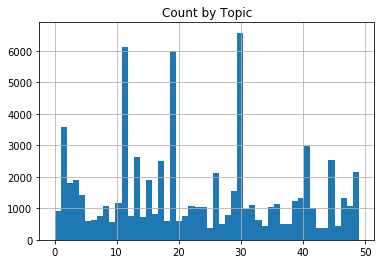

In [15]:
data['top_topic'].hist(bins=50)
plt.title('Count by Topic')
plt.show()

In [19]:
lda_50_45 = gensim.models.ldamodel.LdaModel.load('lda_50_45_model')

In [21]:
topics_to_csv(data, 50)

## Evaluate Categories

In [107]:
def eval_cat(df, num_topics, city):
    df_raw = pd.read_csv('/Users/alenastern/Google Drive File Stream/My Drive/Alena_Project/PR_Data/{}.csv'.format(city))
    
    df_raw_gp = df_raw.groupby('Dept').count()
    df_raw_gp['Summary'].plot(kind = 'bar')
    title = 'PRR Departments for {}'.format(city)
    plt.title(title)
    plt.show()
    
    df_city = df[df['city'] == city]
    df_merge = df_city.merge(df_raw, how ='left', on = 'Summary')
    df_merge['top_topic'] = pd.to_numeric(df_merge['top_topic'])
    for topic in range(0, num_topics):
        df_sub = df_merge[df_merge['top_topic'] == topic]
        df_gp = df_sub.groupby('Dept').count()
        df_gp['Summary'].plot(kind='bar')
        title = 'Departments for topic {} in {}'.format(topic, city)
        plt.title(title)
        plt.show()

In [89]:
city_list = ['Bainbridge', 'LasCruces', 'FortCollins', 'Mercer', 'Nola', 'Oakland', 'PaloAlto', 'Redmond', 
             'SanFrancisco', 'Vallejo']
fp = 'topics/lda_20_45_topics.csv'
df = pd.read_csv(fp)

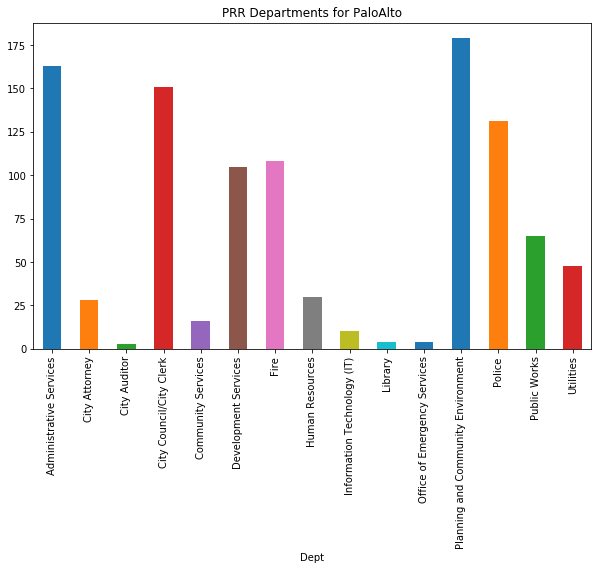

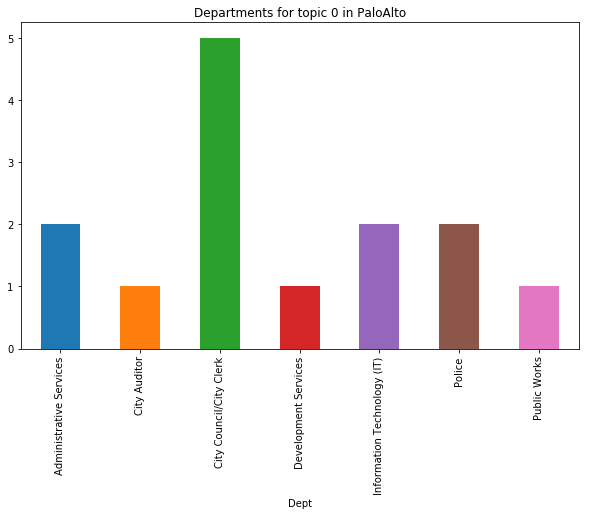

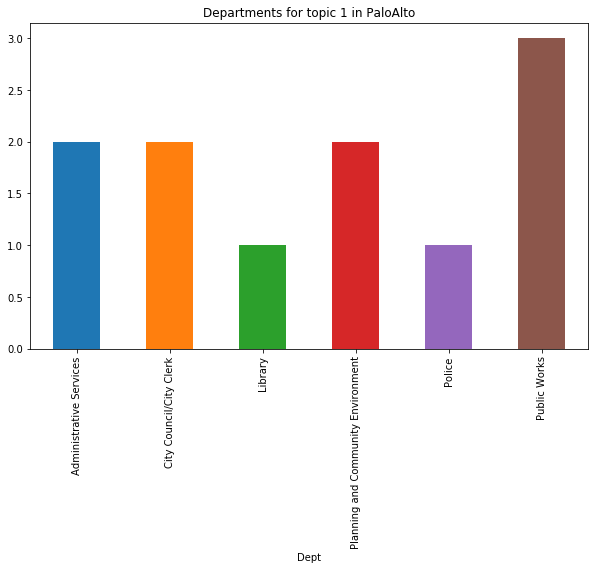

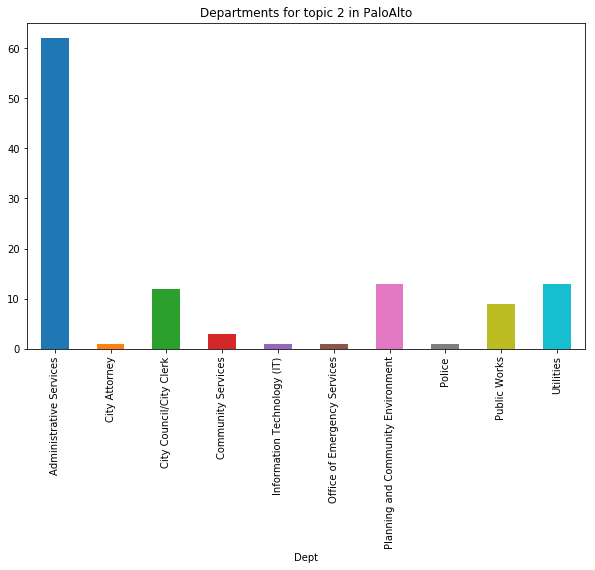

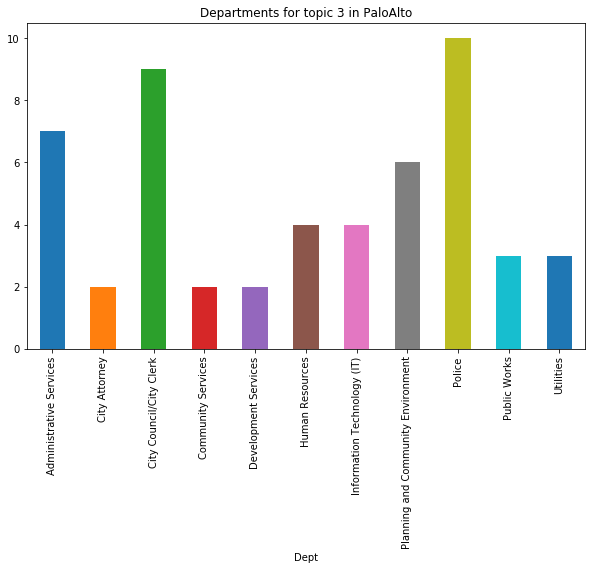

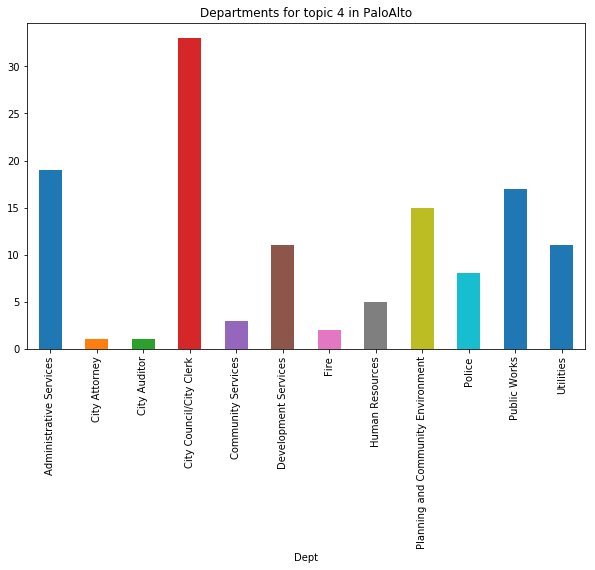

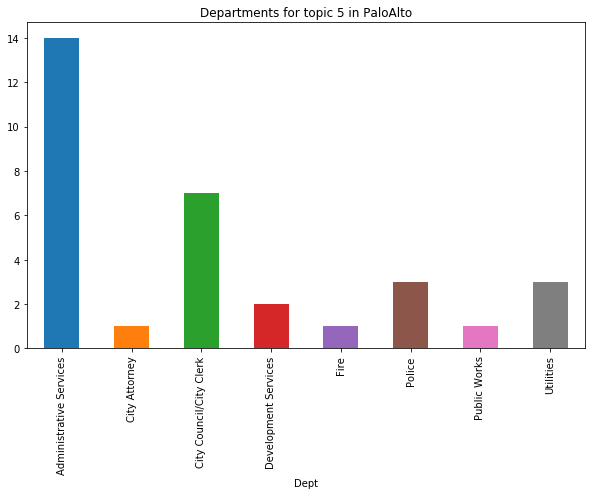

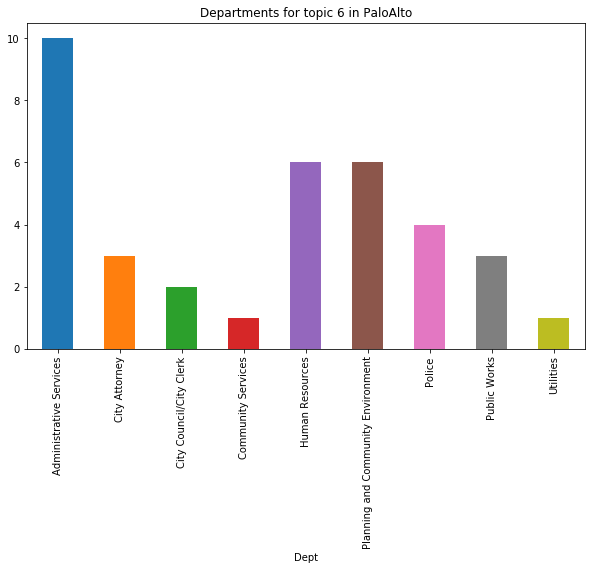

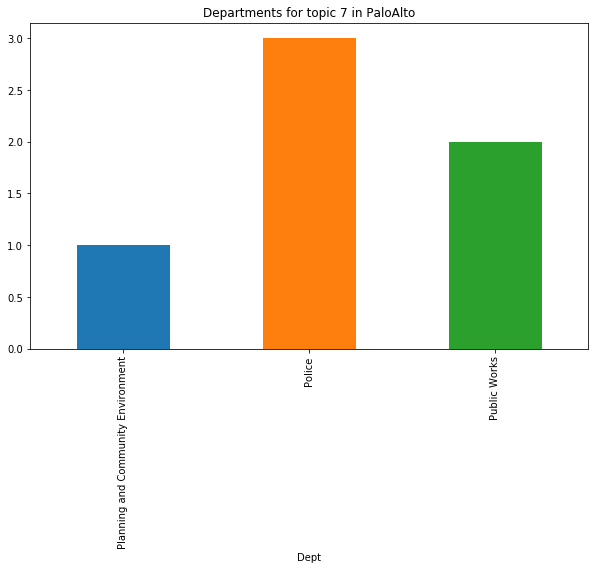

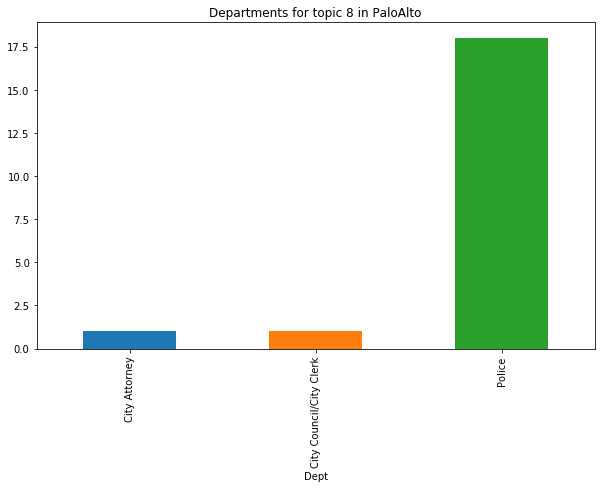

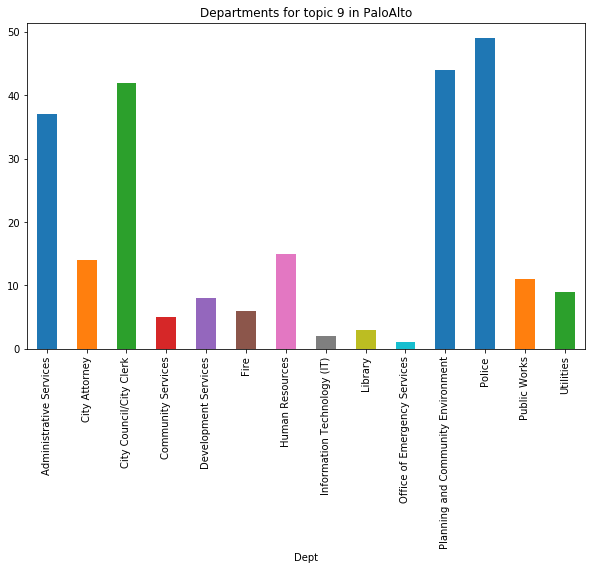

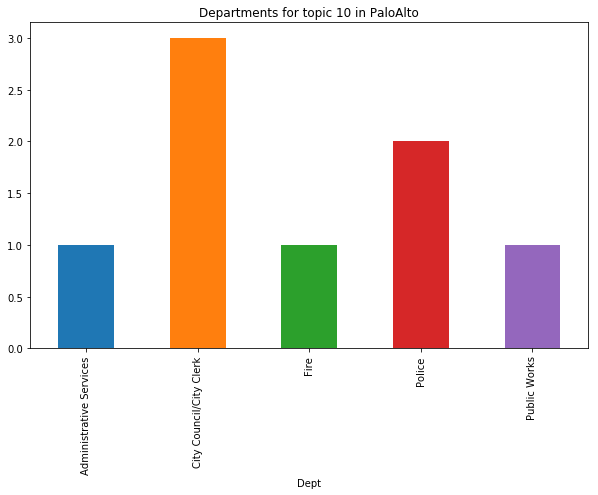

TypeError: Empty 'DataFrame': no numeric data to plot

In [115]:
eval_cat(df, 20, 'PaloAlto')

In [44]:
final_model = gensim.models.ldamodel.LdaModel.load('lda_data_avg')
final_model.show_topics(num_topics=60, formatted=False)

[(0,
  [('security', 0.06084858),
   ('training', 0.040253002),
   ('administration', 0.029152717),
   ('structural', 0.025652435),
   ('break', 0.0247658),
   ('entitle', 0.02199222),
   ('transfer', 0.02094757),
   ('produce', 0.020075262),
   ('respectfully', 0.01951992),
   ('fringe', 0.018698012)]),
 (1,
  [('contract', 0.08568184),
   ('current', 0.051786162),
   ('contractor', 0.03925664),
   ('standard', 0.03693132),
   ('subcontractor', 0.03452668),
   ('general', 0.029704051),
   ('recent', 0.028515091),
   ('hearing', 0.02428295),
   ('schedule', 0.023623805),
   ('provision', 0.020516315)]),
 (2,
  [('location', 0.121947184),
   ('footage', 0.05488819),
   ('procurement', 0.048041817),
   ('five', 0.047510136),
   ('old', 0.038167704),
   ('insured', 0.034928575),
   ('form', 0.032468673),
   ('subdivision', 0.02881338),
   ('pl', 0.027478669),
   ('civil', 0.022515768)]),
 (3,
  [('result', 0.069041744),
   ('perform', 0.062193487),
   ('design', 0.05583477),
   ('burglary

### Load Best Model and Data

In [74]:
final_model = gensim.models.ldamodel.LdaModel.load('lda_data_c2000_3_2')
final_fp = 'topics/lda_data_c2000_3_2.csv'

In [90]:
final_model.show_topics(num_topics=60, formatted=False)

[(0,
  [('ref', 0.12964335),
   ('since', 0.12633274),
   ('child', 0.05254812),
   ('exceed', 0.05003827),
   ('housing', 0.046684396),
   ('family', 0.046582364),
   ('relevant', 0.034656283),
   ('investigate', 0.030152533),
   ('signal', 0.026070984),
   ('abuse', 0.023894273)]),
 (1,
  [('job', 0.04036155),
   ('doc', 0.034017622),
   ('live', 0.03323585),
   ('association', 0.027101738),
   ('son', 0.025491267),
   ('description', 0.02513783),
   ('daughter', 0.024561983),
   ('create', 0.022989985),
   ('receipt', 0.02265158),
   ('miss', 0.02187046)]),
 (2,
  [('intersection', 0.07643916),
   ('steal', 0.069572784),
   ('info', 0.04923086),
   ('medical', 0.043133166),
   ('view', 0.036689773),
   ('tell', 0.03656593),
   ('foot', 0.021272397),
   ('directly', 0.019169154),
   ('procurement', 0.017022246),
   ('evaluation', 0.0156686)]),
 (3,
  [('traffic', 0.17774299),
   ('client', 0.10486326),
   ('related', 0.057885926),
   ('tpd', 0.051455863),
   ('assist', 0.0406475),
  

## Identify Most Popular Catgories

### "Winner take all" popularity metric:
* Scoring Rules:
    * Only the topic that composes the largest share of a document scores "points" for its "Adjusted Popularity" total.
    * If a topic composes the largest share of that document, its "points" are its composition score.


In [75]:
# categorize data by final model identify highest topics
final_df = highest_topic(final_fp)
final_df = final_df[['top_topic', 'top_topic_comp']]

topic_gp = final_df.groupby('top_topic').sum()
topic_gp.reset_index(inplace = True)
topic_gp.rename(index=str, columns={"top_topic_comp": "total_pop"}, inplace = True)
topic_gp = topic_gp[['top_topic', 'total_pop']]

topic_gp.sort_values(by=['top_topic'], ascending = True)

# add in topic words
words_in_topics = [tup[1] for tup in final_model.show_topics(num_topics=60, formatted=False)] # update w/ winning model
topic_gp['topic'] = words_in_topics

topic_gp[["topic1", "topic2", "topic3", "topic4", 
       "topic5", "topic6", "topic7", "topic8", "topic9", "topic10"]] = topic_gp.topic.apply(pd.Series)

topic_gp = topic_gp.sort_values(by='total_pop', ascending=False)
topic_gp

,top_topic,total_pop,topic,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
32,32,3425.183243,"[(insurance, 0.09007677), (type, 0.06883491), (insure, 0.058383524), (location, 0.057834793), (number, 0.055556744), (occurrence, 0.052623488), (transactionreference, 0.05044821), (reportcase, 0.04976547), (reportcase_number, 0.049746525), (occurrence_location, 0.049375195)]","(insurance, 0.09007677)","(type, 0.06883491)","(insure, 0.058383524)","(location, 0.057834793)","(number, 0.055556744)","(occurrence, 0.052623488)","(transactionreference, 0.05044821)","(reportcase, 0.04976547)","(reportcase_number, 0.049746525)","(occurrence_location, 0.049375195)"
43,43,1567.044579,"[(accident, 0.4555495), (location, 0.14451806), (auto, 0.088106245), (auto_accident, 0.07831995), (insured, 0.030857235), (insure, 0.011330121), (wife, 0.008657144), (bear, 0.007452927), (pemco, 0.0061195903), (left, 0.0047813244)]","(accident, 0.4555495)","(location, 0.14451806)","(auto, 0.088106245)","(auto_accident, 0.07831995)","(insured, 0.030857235)","(insure, 0.011330121)","(wife, 0.008657144)","(bear, 0.007452927)","(pemco, 0.0061195903)","(left, 0.0047813244)"
26,26,1476.982562,"[(offense, 0.077358924), (duo, 0.04940976), (completion, 0.04651836), (gang, 0.043948654), (rent, 0.022763923), (ce, 0.021691823), (packet, 0.021130145), (particularly, 0.018434653), (napsutilitiesnatcom, 0.014517769), (conviction, 0.01262904)]","(offense, 0.077358924)","(duo, 0.04940976)","(completion, 0.04651836)","(gang, 0.043948654)","(rent, 0.022763923)","(ce, 0.021691823)","(packet, 0.021130145)","(particularly, 0.018434653)","(napsutilitiesnatcom, 0.014517769)","(conviction, 0.01262904)"
25,25,1449.305527,"[(violation, 0.12154185), (code, 0.0935716), (code_violation, 0.05849182), (property, 0.053911682), (open, 0.04678087), (zone, 0.04150265), (building, 0.03822236), (fire, 0.029731842), (permit, 0.026363298), (fire_code, 0.024953926)]","(violation, 0.12154185)","(code, 0.0935716)","(code_violation, 0.05849182)","(property, 0.053911682)","(open, 0.04678087)","(zone, 0.04150265)","(building, 0.03822236)","(fire, 0.029731842)","(permit, 0.026363298)","(fire_code, 0.024953926)"
36,36,1335.217932,"[(permit, 0.20949204), (building, 0.15088484), (inspection, 0.06672379), (fire, 0.055593174), (build, 0.05167053), (building_permit, 0.04788993), (improvement, 0.022535736), (locate, 0.021239154), (interested, 0.021075092), (issue, 0.019800058)]","(permit, 0.20949204)","(building, 0.15088484)","(inspection, 0.06672379)","(fire, 0.055593174)","(build, 0.05167053)","(building_permit, 0.04788993)","(improvement, 0.022535736)","(locate, 0.021239154)","(interested, 0.021075092)","(issue, 0.019800058)"
45,45,1306.928269,"[(statement, 0.099000454), (collision, 0.098334774), (call, 0.05753599), (log, 0.053481717), (witness, 0.049168784), (photograph, 0.044270713), (nineoneone, 0.042678934), (recording, 0.03919327), (note, 0.034071025), (witness_statement, 0.029257316)]","(statement, 0.099000454)","(collision, 0.098334774)","(call, 0.05753599)","(log, 0.053481717)","(witness, 0.049168784)","(photograph, 0.044270713)","(nineoneone, 0.042678934)","(recording, 0.03919327)","(note, 0.034071025)","(witness_statement, 0.029257316)"
6,6,1226.587506,"[(case, 0.3620435), (number, 0.24301922), (case_number, 0.04746081), (lot, 0.046570048), (parking, 0.035665914), (associate, 0.028080955), (mention, 0.015397903), (pedestrian, 0.014462032), (remove, 0.014372728), (drug, 0.010990068)]","(case, 0.3620435)","(number, 0.24301922)","(case_number, 0.04746081)","(lot, 0.046570048)","(parking, 0.035665914)","(associate, 0.028080955)","(mention, 0.015397903)","(pedestrian, 0.014462032)","(remove, 0.014372728)","(drug, 0.010990068)"
24,24,1138.694076,"[(environmental, 0.057950664), (hazardous, 0.052298173), (storage, 0.048452124), (material, 0.047354627), (site, 0.038020436), (hazardous_material, 0.037162572), (assessment, 0.03470417), (property, 0.03457829), (phase, 0.024584506), (site_assess

## "Winner Take All with Thresholds" Rules:

Scoring Rules:
* Same as "Winner Take All", except a winning topic must compose at least a certain threshold of a document to get any points.
* We'll try 0.2 (low) and 0.5 (high) thresholds.

In [13]:
def winner_thresh(fp, thresh):
    final_df = highest_topic(fp)
    final_df = final_df[['top_topic', 'top_topic_comp']]


    final_df = final_df[final_df['top_topic_comp'] >= thresh]
    topic_gp = final_df.groupby('top_topic').sum()
    topic_gp.reset_index(inplace = True)
    topic_gp.rename(index=str, columns={"top_topic_comp": "total_pop"}, inplace = True)
    topic_gp = topic_gp[['top_topic', 'total_pop']]

    topic_gp.sort_values(by=['top_topic'], ascending = True)

    # add in topic words
    words_in_topics = [tup[1] for tup in final_model.show_topics(num_topics=60, formatted=False)] # update w/ winning model
    topic_gp['topic'] = words_in_topics

    topic_gp[["topic1", "topic2", "topic3", "topic4", 
       "topic5", "topic6", "topic7", "topic8", "topic9", "topic10"]] = topic_gp.topic.apply(pd.Series)

    topic_gp = topic_gp.sort_values(by='total_pop', ascending=False)
    return topic_gp

In [76]:
topic2 = winner_thresh(final_fp, 0.2)
topic5 = winner_thresh(final_fp, 0.5)

In [77]:
topic5

,top_topic,total_pop,topic,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
32,32,3229.267509,"[(insurance, 0.09007677), (type, 0.06883491), (insure, 0.058383524), (location, 0.057834793), (number, 0.055556744), (occurrence, 0.052623488), (transactionreference, 0.05044821), (reportcase, 0.04976547), (reportcase_number, 0.049746525), (occurrence_location, 0.049375195)]","(insurance, 0.09007677)","(type, 0.06883491)","(insure, 0.058383524)","(location, 0.057834793)","(number, 0.055556744)","(occurrence, 0.052623488)","(transactionreference, 0.05044821)","(reportcase, 0.04976547)","(reportcase_number, 0.049746525)","(occurrence_location, 0.049375195)"
26,26,1345.794279,"[(offense, 0.077358924), (duo, 0.04940976), (completion, 0.04651836), (gang, 0.043948654), (rent, 0.022763923), (ce, 0.021691823), (packet, 0.021130145), (particularly, 0.018434653), (napsutilitiesnatcom, 0.014517769), (conviction, 0.01262904)]","(offense, 0.077358924)","(duo, 0.04940976)","(completion, 0.04651836)","(gang, 0.043948654)","(rent, 0.022763923)","(ce, 0.021691823)","(packet, 0.021130145)","(particularly, 0.018434653)","(napsutilitiesnatcom, 0.014517769)","(conviction, 0.01262904)"
43,43,1246.876059,"[(accident, 0.4555495), (location, 0.14451806), (auto, 0.088106245), (auto_accident, 0.07831995), (insured, 0.030857235), (insure, 0.011330121), (wife, 0.008657144), (bear, 0.007452927), (pemco, 0.0061195903), (left, 0.0047813244)]","(accident, 0.4555495)","(location, 0.14451806)","(auto, 0.088106245)","(auto_accident, 0.07831995)","(insured, 0.030857235)","(insure, 0.011330121)","(wife, 0.008657144)","(bear, 0.007452927)","(pemco, 0.0061195903)","(left, 0.0047813244)"
25,25,916.066887,"[(violation, 0.12154185), (code, 0.0935716), (code_violation, 0.05849182), (property, 0.053911682), (open, 0.04678087), (zone, 0.04150265), (building, 0.03822236), (fire, 0.029731842), (permit, 0.026363298), (fire_code, 0.024953926)]","(violation, 0.12154185)","(code, 0.0935716)","(code_violation, 0.05849182)","(property, 0.053911682)","(open, 0.04678087)","(zone, 0.04150265)","(building, 0.03822236)","(fire, 0.029731842)","(permit, 0.026363298)","(fire_code, 0.024953926)"
45,45,750.145867,"[(statement, 0.099000454), (collision, 0.098334774), (call, 0.05753599), (log, 0.053481717), (witness, 0.049168784), (photograph, 0.044270713), (nineoneone, 0.042678934), (recording, 0.03919327), (note, 0.034071025), (witness_statement, 0.029257316)]","(statement, 0.099000454)","(collision, 0.098334774)","(call, 0.05753599)","(log, 0.053481717)","(witness, 0.049168784)","(photograph, 0.044270713)","(nineoneone, 0.042678934)","(recording, 0.03919327)","(note, 0.034071025)","(witness_statement, 0.029257316)"
6,6,645.478954,"[(case, 0.3620435), (number, 0.24301922), (case_number, 0.04746081), (lot, 0.046570048), (parking, 0.035665914), (associate, 0.028080955), (mention, 0.015397903), (pedestrian, 0.014462032), (remove, 0.014372728), (drug, 0.010990068)]","(case, 0.3620435)","(number, 0.24301922)","(case_number, 0.04746081)","(lot, 0.046570048)","(parking, 0.035665914)","(associate, 0.028080955)","(mention, 0.015397903)","(pedestrian, 0.014462032)","(remove, 0.014372728)","(drug, 0.010990068)"
24,24,608.133902,"[(environmental, 0.057950664), (hazardous, 0.052298173), (storage, 0.048452124), (material, 0.047354627), (site, 0.038020436), (hazardous_material, 0.037162572), (assessment, 0.03470417), (property, 0.03457829), (phase, 0.024584506), (site_assessment, 0.021651288)]","(environmental, 0.057950664)","(hazardous, 0.052298173)","(storage, 0.048452124)","(material, 0.047354627)","(site, 0.038020436)","(hazardous_material, 0.037162572)","(assessment, 0.03470417)","(property, 0.03457829)","(phase, 0.024584506)","(site_assessment, 0.021651288)"
58,58,575.530580,"[(vehicle, 0.12896657), (theft, 0.06858158), (crime, 0.05966813), (victim, 0.05952646), (police department, 0.041175667), (burglary, 0.036248926), (location, 0.032808065), (respond, 0.03189742), (agency, 0.02929

In [78]:
topic2

,top_topic,total_pop,topic,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
32,32,3419.425604,"[(insurance, 0.09007677), (type, 0.06883491), (insure, 0.058383524), (location, 0.057834793), (number, 0.055556744), (occurrence, 0.052623488), (transactionreference, 0.05044821), (reportcase, 0.04976547), (reportcase_number, 0.049746525), (occurrence_location, 0.049375195)]","(insurance, 0.09007677)","(type, 0.06883491)","(insure, 0.058383524)","(location, 0.057834793)","(number, 0.055556744)","(occurrence, 0.052623488)","(transactionreference, 0.05044821)","(reportcase, 0.04976547)","(reportcase_number, 0.049746525)","(occurrence_location, 0.049375195)"
43,43,1556.152075,"[(accident, 0.4555495), (location, 0.14451806), (auto, 0.088106245), (auto_accident, 0.07831995), (insured, 0.030857235), (insure, 0.011330121), (wife, 0.008657144), (bear, 0.007452927), (pemco, 0.0061195903), (left, 0.0047813244)]","(accident, 0.4555495)","(location, 0.14451806)","(auto, 0.088106245)","(auto_accident, 0.07831995)","(insured, 0.030857235)","(insure, 0.011330121)","(wife, 0.008657144)","(bear, 0.007452927)","(pemco, 0.0061195903)","(left, 0.0047813244)"
26,26,1466.654698,"[(offense, 0.077358924), (duo, 0.04940976), (completion, 0.04651836), (gang, 0.043948654), (rent, 0.022763923), (ce, 0.021691823), (packet, 0.021130145), (particularly, 0.018434653), (napsutilitiesnatcom, 0.014517769), (conviction, 0.01262904)]","(offense, 0.077358924)","(duo, 0.04940976)","(completion, 0.04651836)","(gang, 0.043948654)","(rent, 0.022763923)","(ce, 0.021691823)","(packet, 0.021130145)","(particularly, 0.018434653)","(napsutilitiesnatcom, 0.014517769)","(conviction, 0.01262904)"
25,25,1416.518733,"[(violation, 0.12154185), (code, 0.0935716), (code_violation, 0.05849182), (property, 0.053911682), (open, 0.04678087), (zone, 0.04150265), (building, 0.03822236), (fire, 0.029731842), (permit, 0.026363298), (fire_code, 0.024953926)]","(violation, 0.12154185)","(code, 0.0935716)","(code_violation, 0.05849182)","(property, 0.053911682)","(open, 0.04678087)","(zone, 0.04150265)","(building, 0.03822236)","(fire, 0.029731842)","(permit, 0.026363298)","(fire_code, 0.024953926)"
36,36,1271.342315,"[(permit, 0.20949204), (building, 0.15088484), (inspection, 0.06672379), (fire, 0.055593174), (build, 0.05167053), (building_permit, 0.04788993), (improvement, 0.022535736), (locate, 0.021239154), (interested, 0.021075092), (issue, 0.019800058)]","(permit, 0.20949204)","(building, 0.15088484)","(inspection, 0.06672379)","(fire, 0.055593174)","(build, 0.05167053)","(building_permit, 0.04788993)","(improvement, 0.022535736)","(locate, 0.021239154)","(interested, 0.021075092)","(issue, 0.019800058)"
45,45,1267.838588,"[(statement, 0.099000454), (collision, 0.098334774), (call, 0.05753599), (log, 0.053481717), (witness, 0.049168784), (photograph, 0.044270713), (nineoneone, 0.042678934), (recording, 0.03919327), (note, 0.034071025), (witness_statement, 0.029257316)]","(statement, 0.099000454)","(collision, 0.098334774)","(call, 0.05753599)","(log, 0.053481717)","(witness, 0.049168784)","(photograph, 0.044270713)","(nineoneone, 0.042678934)","(recording, 0.03919327)","(note, 0.034071025)","(witness_statement, 0.029257316)"
6,6,1171.145128,"[(case, 0.3620435), (number, 0.24301922), (case_number, 0.04746081), (lot, 0.046570048), (parking, 0.035665914), (associate, 0.028080955), (mention, 0.015397903), (pedestrian, 0.014462032), (remove, 0.014372728), (drug, 0.010990068)]","(case, 0.3620435)","(number, 0.24301922)","(case_number, 0.04746081)","(lot, 0.046570048)","(parking, 0.035665914)","(associate, 0.028080955)","(mention, 0.015397903)","(pedestrian, 0.014462032)","(remove, 0.014372728)","(drug, 0.010990068)"
24,24,1110.782775,"[(environmental, 0.057950664), (hazardous, 0.052298173), (storage, 0.048452124), (material, 0.047354627), (site, 0.038020436), (hazardous_material, 0.037162572), (assessment, 0.03470417), (property, 0.03457829), (phase, 0.024584506), (site_assess

## Partial Credit Approach

* All topics assigned to a given PRR get credit for that PRR's topic composition score, provided the score is above the established threshold

In [79]:
def prop_calc(fp, thresh):
    df = pd.read_csv(fp)
    results_dict = {}
    df['topic_comp'] =  df['topic_comp'].apply(lambda x:  ast.literal_eval(x))
    for row_num in df.index:
        for tup in df.topic_comp[row_num]: 
            if not tup[0] in results_dict:
                if tup[1] >= thresh: 
                    results_dict[tup[0]] = tup[1] 
                else:
                    pass
            if tup[0] in results_dict:
                if tup[1] >= thresh:
                    results_dict[tup[0]] += tup[1] 
                    
    pd_df = pd.DataFrame.from_dict(results_dict, orient = 'index')
    pd_df.reset_index(inplace = True)
    pd_df.rename(index = str, columns = {'index': 'topic', 0: 'total_score'}, inplace = True)
    pd_df.topic = pd.to_numeric(pd_df.topic)
    pd_df = pd_df.sort_values(by=['topic'], ascending = True)

    # add in topic words
    words_in_topics = [tup[1] for tup in final_model.show_topics(num_topics=60, formatted=False)] # update w/ winning model
    pd_df['topic_words'] = words_in_topics

    pd_df[["topic1", "topic2", "topic3", "topic4", 
           "topic5", "topic6", "topic7", "topic8", "topic9", "topic10"]] = pd_df.topic_words.apply(pd.Series)

    
    
    pd_df = pd_df.sort_values(by='total_score', ascending=False)

    return pd_df

In [97]:
pc2 = prop_calc(final_fp, .2)

In [98]:
top_10 = list(pc2.topic[:10])

In [99]:
top_10

[32, 43, 36, 45, 25, 26, 6, 24, 55, 35]

In [81]:
prop_calc(final_fp, .5)

,topic,total_score,topic_words,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
2,32,3230.073427,"[(insurance, 0.09007677), (type, 0.06883491), (insure, 0.058383524), (location, 0.057834793), (number, 0.055556744), (occurrence, 0.052623488), (transactionreference, 0.05044821), (reportcase, 0.04976547), (reportcase_number, 0.049746525), (occurrence_location, 0.049375195)]","(insurance, 0.09007677)","(type, 0.06883491)","(insure, 0.058383524)","(location, 0.057834793)","(number, 0.055556744)","(occurrence, 0.052623488)","(transactionreference, 0.05044821)","(reportcase, 0.04976547)","(reportcase_number, 0.049746525)","(occurrence_location, 0.049375195)"
55,26,1346.302612,"[(offense, 0.077358924), (duo, 0.04940976), (completion, 0.04651836), (gang, 0.043948654), (rent, 0.022763923), (ce, 0.021691823), (packet, 0.021130145), (particularly, 0.018434653), (napsutilitiesnatcom, 0.014517769), (conviction, 0.01262904)]","(offense, 0.077358924)","(duo, 0.04940976)","(completion, 0.04651836)","(gang, 0.043948654)","(rent, 0.022763923)","(ce, 0.021691823)","(packet, 0.021130145)","(particularly, 0.018434653)","(napsutilitiesnatcom, 0.014517769)","(conviction, 0.01262904)"
5,43,1247.630226,"[(accident, 0.4555495), (location, 0.14451806), (auto, 0.088106245), (auto_accident, 0.07831995), (insured, 0.030857235), (insure, 0.011330121), (wife, 0.008657144), (bear, 0.007452927), (pemco, 0.0061195903), (left, 0.0047813244)]","(accident, 0.4555495)","(location, 0.14451806)","(auto, 0.088106245)","(auto_accident, 0.07831995)","(insured, 0.030857235)","(insure, 0.011330121)","(wife, 0.008657144)","(bear, 0.007452927)","(pemco, 0.0061195903)","(left, 0.0047813244)"
26,25,916.604333,"[(violation, 0.12154185), (code, 0.0935716), (code_violation, 0.05849182), (property, 0.053911682), (open, 0.04678087), (zone, 0.04150265), (building, 0.03822236), (fire, 0.029731842), (permit, 0.026363298), (fire_code, 0.024953926)]","(violation, 0.12154185)","(code, 0.0935716)","(code_violation, 0.05849182)","(property, 0.053911682)","(open, 0.04678087)","(zone, 0.04150265)","(building, 0.03822236)","(fire, 0.029731842)","(permit, 0.026363298)","(fire_code, 0.024953926)"
8,45,750.749200,"[(statement, 0.099000454), (collision, 0.098334774), (call, 0.05753599), (log, 0.053481717), (witness, 0.049168784), (photograph, 0.044270713), (nineoneone, 0.042678934), (recording, 0.03919327), (note, 0.034071025), (witness_statement, 0.029257316)]","(statement, 0.099000454)","(collision, 0.098334774)","(call, 0.05753599)","(log, 0.053481717)","(witness, 0.049168784)","(photograph, 0.044270713)","(nineoneone, 0.042678934)","(recording, 0.03919327)","(note, 0.034071025)","(witness_statement, 0.029257316)"
14,6,645.987288,"[(case, 0.3620435), (number, 0.24301922), (case_number, 0.04746081), (lot, 0.046570048), (parking, 0.035665914), (associate, 0.028080955), (mention, 0.015397903), (pedestrian, 0.014462032), (remove, 0.014372728), (drug, 0.010990068)]","(case, 0.3620435)","(number, 0.24301922)","(case_number, 0.04746081)","(lot, 0.046570048)","(parking, 0.035665914)","(associate, 0.028080955)","(mention, 0.015397903)","(pedestrian, 0.014462032)","(remove, 0.014372728)","(drug, 0.010990068)"
1,24,609.033689,"[(environmental, 0.057950664), (hazardous, 0.052298173), (storage, 0.048452124), (material, 0.047354627), (site, 0.038020436), (hazardous_material, 0.037162572), (assessment, 0.03470417), (property, 0.03457829), (phase, 0.024584506), (site_assessment, 0.021651288)]","(environmental, 0.057950664)","(hazardous, 0.052298173)","(storage, 0.048452124)","(material, 0.047354627)","(site, 0.038020436)","(hazardous_material, 0.037162572)","(assessment, 0.03470417)","(property, 0.03457829)","(phase, 0.024584506)","(site_assessment, 0.021651288)"
4,58,576.033358,"[(vehicle, 0.12896657), (theft, 0.06858158), (crime, 0.05966813), (victim, 0.05952646), (police department, 0.041175667), (burglary, 0.036248926), (location, 0.032808065), (respond, 0.03189742), (agency, 0.02929

## Normalize Metrics within a City/County (Dampened Popularity):
* For each city/county, we add up total score fore each topic and then take the log of the total score. We then add up scores across each city/count.
* For winner-take-all, only score for top topic included (provided it is above threshold)
* For partial-credit, scores for all topics included (provided it is above threhsold
* This is an extra control for cities with a large number of PRRs from skewing our results


In [59]:
city_list = ['Arlington', 'Asheville', 'Bainbridge', 'Boulder', 'CathedralCity' ,'Clearwater', 'Dayton', 
            'Denton', 'Everett', 'FortCollins', 'Greensboro', 'Hayward', 'Kirkland', 'LasCruces', 'Lynnwood',
            'Mercer', 'Miami', 'Middleborough', 'Nola', 'Oakland', 'OKC', 'Olympia', 'PaloAlto', 
            'Peoria', 'Pullman', 'RanchoCucamonga', 'Redmond', 'Renton', 'Sacramento', 'SanFrancisco', 
            'Tukwila', 'Vallejo', 'WestSacramento', 'Winchester']

In [68]:
def norm_pop(fp, city_list, thresh, winner_take_all):
    df = pd.read_csv(fp)
    df['topic_comp'] =  df['topic_comp'].apply(lambda x:  ast.literal_eval(x))
    
    list_of_domain_dicts = []
    popularity_dict = {}
    
    for city in city_list:
        
        results_dict = {}
        
        #get our df only of rows from a given city/state domain
        city_df = df[df.city == city]
        
        for row_num in city_df.index:
            tup_list = city_df.topic_comp[row_num] #list of (topic, doc composition) tuples
            
            if winner_take_all:
        
                #return only the tuple w/highest topic composition value
                winner_tuple = max(tup_list, key=lambda item:item[1])  

                if not winner_tuple[0] in results_dict: #if not in dict, add it with its TOTAL VIEWS score
                    if winner_tuple[1] > thresh:
                        results_dict[winner_tuple[0]] = winner_tuple[1] 
                else:
                    pass

                if winner_tuple[0] in results_dict: #if in dict, increment that key's value with score
                    if winner_tuple[1] > thresh:
                        results_dict[winner_tuple[0]] += winner_tuple[1]
                    pass
            else:
                for tup in tup_list: 
                    if not tup[0] in results_dict:
                        if tup[1] >= thresh: 
                            results_dict[tup[0]] = tup[1] 
                    else:
                        pass
                    if tup[0] in results_dict:
                        if tup[1] >= thresh:
                            results_dict[tup[0]] += tup[1] 
            
        #when loop of domain_df is finished, take log of all keys in dict
        log_dict = {}
        for k,v in results_dict.items():
            log_dict[k] = np.log(v)
        
        #now we have a polished dict of topic numbers as keys and log of all views/DLs as values; append it to list
        list_of_domain_dicts.append(log_dict)
    
    #use Counter() object to sync our dictionaries
    c = Counter()
    for d in list_of_domain_dicts:
        c.update(d)
    
    popularity_dict = dict(c)
    
    pd_df = pd.DataFrame.from_dict(popularity_dict, orient = 'index')
    pd_df.reset_index(inplace = True)
    pd_df.rename(index = str, columns = {'index': 'topic', 0: 'total_score'}, inplace = True)
    pd_df.topic = pd.to_numeric(pd_df.topic)
    pd_df = pd_df.sort_values(by=['topic'], ascending = True)

    # add in topic words
    words_in_topics = [tup[1] for tup in final_model.show_topics(num_topics=60, formatted=False)] # update w/ winning model
    pd_df['topic_words'] = words_in_topics

    pd_df[["topic1", "topic2", "topic3", "topic4", 
           "topic5", "topic6", "topic7", "topic8", "topic9", "topic10"]] = pd_df.topic_words.apply(pd.Series)

    
    
    pd_df = pd_df.sort_values(by='total_score', ascending=False)

    return pd_df

In [82]:
norm_pop(final_fp, city_list, .5, True)

,topic,total_score,topic_words,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
26,25,74.023614,"[(violation, 0.12154185), (code, 0.0935716), (code_violation, 0.05849182), (property, 0.053911682), (open, 0.04678087), (zone, 0.04150265), (building, 0.03822236), (fire, 0.029731842), (permit, 0.026363298), (fire_code, 0.024953926)]","(violation, 0.12154185)","(code, 0.0935716)","(code_violation, 0.05849182)","(property, 0.053911682)","(open, 0.04678087)","(zone, 0.04150265)","(building, 0.03822236)","(fire, 0.029731842)","(permit, 0.026363298)","(fire_code, 0.024953926)"
1,24,67.119717,"[(environmental, 0.057950664), (hazardous, 0.052298173), (storage, 0.048452124), (material, 0.047354627), (site, 0.038020436), (hazardous_material, 0.037162572), (assessment, 0.03470417), (property, 0.03457829), (phase, 0.024584506), (site_assessment, 0.021651288)]","(environmental, 0.057950664)","(hazardous, 0.052298173)","(storage, 0.048452124)","(material, 0.047354627)","(site, 0.038020436)","(hazardous_material, 0.037162572)","(assessment, 0.03470417)","(property, 0.03457829)","(phase, 0.024584506)","(site_assessment, 0.021651288)"
7,36,66.195122,"[(permit, 0.20949204), (building, 0.15088484), (inspection, 0.06672379), (fire, 0.055593174), (build, 0.05167053), (building_permit, 0.04788993), (improvement, 0.022535736), (locate, 0.021239154), (interested, 0.021075092), (issue, 0.019800058)]","(permit, 0.20949204)","(building, 0.15088484)","(inspection, 0.06672379)","(fire, 0.055593174)","(build, 0.05167053)","(building_permit, 0.04788993)","(improvement, 0.022535736)","(locate, 0.021239154)","(interested, 0.021075092)","(issue, 0.019800058)"
8,45,46.479797,"[(statement, 0.099000454), (collision, 0.098334774), (call, 0.05753599), (log, 0.053481717), (witness, 0.049168784), (photograph, 0.044270713), (nineoneone, 0.042678934), (recording, 0.03919327), (note, 0.034071025), (witness_statement, 0.029257316)]","(statement, 0.099000454)","(collision, 0.098334774)","(call, 0.05753599)","(log, 0.053481717)","(witness, 0.049168784)","(photograph, 0.044270713)","(nineoneone, 0.042678934)","(recording, 0.03919327)","(note, 0.034071025)","(witness_statement, 0.029257316)"
5,43,45.806164,"[(accident, 0.4555495), (location, 0.14451806), (auto, 0.088106245), (auto_accident, 0.07831995), (insured, 0.030857235), (insure, 0.011330121), (wife, 0.008657144), (bear, 0.007452927), (pemco, 0.0061195903), (left, 0.0047813244)]","(accident, 0.4555495)","(location, 0.14451806)","(auto, 0.088106245)","(auto_accident, 0.07831995)","(insured, 0.030857235)","(insure, 0.011330121)","(wife, 0.008657144)","(bear, 0.007452927)","(pemco, 0.0061195903)","(left, 0.0047813244)"
0,19,44.652293,"[(plan, 0.16272427), (site, 0.058773022), (development, 0.03314357), (site_plan, 0.029649511), (business, 0.026094876), (approve, 0.025081016), (project, 0.021183904), (incur, 0.02000974), (set, 0.01808708), (resolution, 0.016408812)]","(plan, 0.16272427)","(site, 0.058773022)","(development, 0.03314357)","(site_plan, 0.029649511)","(business, 0.026094876)","(approve, 0.025081016)","(project, 0.021183904)","(incur, 0.02000974)","(set, 0.01808708)","(resolution, 0.016408812)"
3,55,44.197013,"[(police, 0.40409163), (department, 0.18174466), (officer, 0.083707616), (police_department, 0.049799096), (scene, 0.023843804), (run, 0.02058522), (time, 0.015976014), (credit, 0.015368369), (police_case, 0.014374561), (force, 0.009649579)]","(police, 0.40409163)","(department, 0.18174466)","(officer, 0.083707616)","(police_department, 0.049799096)","(scene, 0.023843804)","(run, 0.02058522)","(time, 0.015976014)","(credit, 0.015368369)","(police_case, 0.014374561)","(force, 0.009649579)"
6,35,43.759988,"[(incident, 0.5880926), (involve, 0.046209656), (esa, 0.041035466), (possible, 0.033443417), (building_code, 0.02806724), (soon, 0.018115232), (inspector, 0.01739411), (sr, 0.0119086355), (annexation, 0.011474327), (designated, 0.0111274775)]","(incident, 0.5880926)","(involve, 0.046209

In [71]:
norm_pop(final_fp, city_list, .2, True)

,topic,total_score,topic_words,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
9,25,94.897316,"[(property, 0.11844734), (code, 0.096418984), (violation, 0.08305787), (code_violation, 0.04703661), (open, 0.03595328), (locate, 0.034536164), (building, 0.02666049), (zone, 0.02636629), (parcel, 0.025382405), (property_locate, 0.025313752)]","(property, 0.11844734)","(code, 0.096418984)","(violation, 0.08305787)","(code_violation, 0.04703661)","(open, 0.03595328)","(locate, 0.034536164)","(building, 0.02666049)","(zone, 0.02636629)","(parcel, 0.025382405)","(property_locate, 0.025313752)"
8,46,94.141291,"[(environmental, 0.038781106), (storage, 0.03870892), (hazardous, 0.037277978), (material, 0.036017682), (tank, 0.035313383), (property, 0.028906591), (storage_tank, 0.028416267), (site, 0.026625015), (hazardous_material, 0.024578027), (fire, 0.02168107)]","(environmental, 0.038781106)","(storage, 0.03870892)","(hazardous, 0.037277978)","(material, 0.036017682)","(tank, 0.035313383)","(property, 0.028906591)","(storage_tank, 0.028416267)","(site, 0.026625015)","(hazardous_material, 0.024578027)","(fire, 0.02168107)"
6,11,82.005565,"[(permit, 0.25334737), (building, 0.09925781), (issue, 0.07698668), (application, 0.06600174), (building_permit, 0.052853808), (build, 0.038809605), (enforcement, 0.030616948), (code, 0.027994283), (llc, 0.024062535), (code_enforcement, 0.023302367)]","(permit, 0.25334737)","(building, 0.09925781)","(issue, 0.07698668)","(application, 0.06600174)","(building_permit, 0.052853808)","(build, 0.038809605)","(enforcement, 0.030616948)","(code, 0.027994283)","(llc, 0.024062535)","(code_enforcement, 0.023302367)"
3,28,71.882671,"[(case, 0.23487267), (police, 0.13314094), (department, 0.08471936), (police_department, 0.06897799), (number, 0.068234414), (officer, 0.034850124), (case_number, 0.030363493), (assault, 0.023841912), (camera, 0.023719933), (client, 0.018820764)]","(case, 0.23487267)","(police, 0.13314094)","(department, 0.08471936)","(police_department, 0.06897799)","(number, 0.068234414)","(officer, 0.034850124)","(case_number, 0.030363493)","(assault, 0.023841912)","(camera, 0.023719933)","(client, 0.018820764)"
34,49,67.105406,"[(andor, 0.044429243), (email, 0.03508073), (correspondence, 0.03206165), (communication, 0.031114161), (write, 0.02404813), (letter, 0.021114452), (miami, 0.01906243), (purchase, 0.017783232), (limited, 0.017265612), (order, 0.017018529)]","(andor, 0.044429243)","(email, 0.03508073)","(correspondence, 0.03206165)","(communication, 0.031114161)","(write, 0.02404813)","(letter, 0.021114452)","(miami, 0.01906243)","(purchase, 0.017783232)","(limited, 0.017265612)","(order, 0.017018529)"
11,34,63.110131,"[(plan, 0.19297686), (building, 0.06566755), (site, 0.0629928), (construction, 0.04032578), (development, 0.03522585), (drawing, 0.034294922), (project, 0.028557368), (original, 0.024296124), (structure, 0.024210991), (approve, 0.022191737)]","(plan, 0.19297686)","(building, 0.06566755)","(site, 0.0629928)","(construction, 0.04032578)","(development, 0.03522585)","(drawing, 0.034294922)","(project, 0.028557368)","(original, 0.024296124)","(structure, 0.024210991)","(approve, 0.022191737)"
13,27,62.859036,"[(fire, 0.17130528), (certificate, 0.0882775), (occupancy, 0.077163), (certificate_occupancy, 0.07075437), (inc, 0.054342214), (proposal, 0.033927895), (inspection, 0.028850788), (lake, 0.028077891), (rfp, 0.027999444), (valley, 0.02508164)]","(fire, 0.17130528)","(certificate, 0.0882775)","(occupancy, 0.077163)","(certificate_occupancy, 0.07075437)","(inc, 0.054342214)","(proposal, 0.033927895)","(inspection, 0.028850788)","(lake, 0.028077891)","(rfp, 0.027999444)","(valley, 0.02508164)"
12,33,62.111210,"[(police, 0.38558546), (police_report, 0.26442093), (copy_police, 0.07319081), (involve, 0.023189347), (happen, 0.023175055), (officer, 0.020870361), (preferably, 0.013577353), (william, 0.008520721), (define, 0.007569092), (erosion, 0.007173538)]","(pol

In [72]:
norm_pop('topics/lda_data_avg.csv', city_list, .5, False)

,topic,total_score,topic_words,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,46,80.473838,"[(environmental, 0.038781106), (storage, 0.03870892), (hazardous, 0.037277978), (material, 0.036017682), (tank, 0.035313383), (property, 0.028906591), (storage_tank, 0.028416267), (site, 0.026625015), (hazardous_material, 0.024578027), (fire, 0.02168107)]","(environmental, 0.038781106)","(storage, 0.03870892)","(hazardous, 0.037277978)","(material, 0.036017682)","(tank, 0.035313383)","(property, 0.028906591)","(storage_tank, 0.028416267)","(site, 0.026625015)","(hazardous_material, 0.024578027)","(fire, 0.02168107)"
26,25,71.703763,"[(property, 0.11844734), (code, 0.096418984), (violation, 0.08305787), (code_violation, 0.04703661), (open, 0.03595328), (locate, 0.034536164), (building, 0.02666049), (zone, 0.02636629), (parcel, 0.025382405), (property_locate, 0.025313752)]","(property, 0.11844734)","(code, 0.096418984)","(violation, 0.08305787)","(code_violation, 0.04703661)","(open, 0.03595328)","(locate, 0.034536164)","(building, 0.02666049)","(zone, 0.02636629)","(parcel, 0.025382405)","(property_locate, 0.025313752)"
10,33,52.784667,"[(police, 0.38558546), (police_report, 0.26442093), (copy_police, 0.07319081), (involve, 0.023189347), (happen, 0.023175055), (officer, 0.020870361), (preferably, 0.013577353), (william, 0.008520721), (define, 0.007569092), (erosion, 0.007173538)]","(police, 0.38558546)","(police_report, 0.26442093)","(copy_police, 0.07319081)","(involve, 0.023189347)","(happen, 0.023175055)","(officer, 0.020870361)","(preferably, 0.013577353)","(william, 0.008520721)","(define, 0.007569092)","(erosion, 0.007173538)"
4,11,50.281388,"[(permit, 0.25334737), (building, 0.09925781), (issue, 0.07698668), (application, 0.06600174), (building_permit, 0.052853808), (build, 0.038809605), (enforcement, 0.030616948), (code, 0.027994283), (llc, 0.024062535), (code_enforcement, 0.023302367)]","(permit, 0.25334737)","(building, 0.09925781)","(issue, 0.07698668)","(application, 0.06600174)","(building_permit, 0.052853808)","(build, 0.038809605)","(enforcement, 0.030616948)","(code, 0.027994283)","(llc, 0.024062535)","(code_enforcement, 0.023302367)"
11,28,49.217309,"[(case, 0.23487267), (police, 0.13314094), (department, 0.08471936), (police_department, 0.06897799), (number, 0.068234414), (officer, 0.034850124), (case_number, 0.030363493), (assault, 0.023841912), (camera, 0.023719933), (client, 0.018820764)]","(case, 0.23487267)","(police, 0.13314094)","(department, 0.08471936)","(police_department, 0.06897799)","(number, 0.068234414)","(officer, 0.034850124)","(case_number, 0.030363493)","(assault, 0.023841912)","(camera, 0.023719933)","(client, 0.018820764)"
2,16,48.704146,"[(accident, 0.2849368), (vehicle, 0.12029181), (car, 0.09771038), (accident_report, 0.09726428), (auto, 0.055827025), (auto_accident, 0.04751926), (driver, 0.027048565), (crash, 0.018127494), (southcenter, 0.014410524), (location, 0.012508029)]","(accident, 0.2849368)","(vehicle, 0.12029181)","(car, 0.09771038)","(accident_report, 0.09726428)","(auto, 0.055827025)","(auto_accident, 0.04751926)","(driver, 0.027048565)","(crash, 0.018127494)","(southcenter, 0.014410524)","(location, 0.012508029)"
3,26,44.989554,"[(incident, 0.43024704), (incident_report, 0.12703474), (past, 0.059724797), (involve, 0.033708733), (report_incident, 0.033425808), (apt, 0.033390436), (full, 0.02214534), (referenced, 0.010308894), (delinquent, 0.008757952), (publicly, 0.008698122)]","(incident, 0.43024704)","(incident_report, 0.12703474)","(past, 0.059724797)","(involve, 0.033708733)","(report_incident, 0.033425808)","(apt, 0.033390436)","(full, 0.02214534)","(referenced, 0.010308894)","(delinquent, 0.008757952)","(publicly, 0.008698122)"
21,27,40.551899,"[(fire, 0.17130528), (certificate, 0.0882775), (occupancy, 0.077163), (certificate_occupancy, 0.07075437), (inc, 0.054342214), (proposal, 0.033927895), (inspection, 0.028850788), (lake, 0.028077891), (rfp, 0.0279

In [73]:
norm_pop('topics/lda_data_avg.csv', city_list, .2, False)

,topic,total_score,topic_words,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
2,25,100.537252,"[(property, 0.11844734), (code, 0.096418984), (violation, 0.08305787), (code_violation, 0.04703661), (open, 0.03595328), (locate, 0.034536164), (building, 0.02666049), (zone, 0.02636629), (parcel, 0.025382405), (property_locate, 0.025313752)]","(property, 0.11844734)","(code, 0.096418984)","(violation, 0.08305787)","(code_violation, 0.04703661)","(open, 0.03595328)","(locate, 0.034536164)","(building, 0.02666049)","(zone, 0.02636629)","(parcel, 0.025382405)","(property_locate, 0.025313752)"
12,46,97.095765,"[(environmental, 0.038781106), (storage, 0.03870892), (hazardous, 0.037277978), (material, 0.036017682), (tank, 0.035313383), (property, 0.028906591), (storage_tank, 0.028416267), (site, 0.026625015), (hazardous_material, 0.024578027), (fire, 0.02168107)]","(environmental, 0.038781106)","(storage, 0.03870892)","(hazardous, 0.037277978)","(material, 0.036017682)","(tank, 0.035313383)","(property, 0.028906591)","(storage_tank, 0.028416267)","(site, 0.026625015)","(hazardous_material, 0.024578027)","(fire, 0.02168107)"
7,11,87.850890,"[(permit, 0.25334737), (building, 0.09925781), (issue, 0.07698668), (application, 0.06600174), (building_permit, 0.052853808), (build, 0.038809605), (enforcement, 0.030616948), (code, 0.027994283), (llc, 0.024062535), (code_enforcement, 0.023302367)]","(permit, 0.25334737)","(building, 0.09925781)","(issue, 0.07698668)","(application, 0.06600174)","(building_permit, 0.052853808)","(build, 0.038809605)","(enforcement, 0.030616948)","(code, 0.027994283)","(llc, 0.024062535)","(code_enforcement, 0.023302367)"
5,28,80.546995,"[(case, 0.23487267), (police, 0.13314094), (department, 0.08471936), (police_department, 0.06897799), (number, 0.068234414), (officer, 0.034850124), (case_number, 0.030363493), (assault, 0.023841912), (camera, 0.023719933), (client, 0.018820764)]","(case, 0.23487267)","(police, 0.13314094)","(department, 0.08471936)","(police_department, 0.06897799)","(number, 0.068234414)","(officer, 0.034850124)","(case_number, 0.030363493)","(assault, 0.023841912)","(camera, 0.023719933)","(client, 0.018820764)"
42,49,76.327142,"[(andor, 0.044429243), (email, 0.03508073), (correspondence, 0.03206165), (communication, 0.031114161), (write, 0.02404813), (letter, 0.021114452), (miami, 0.01906243), (purchase, 0.017783232), (limited, 0.017265612), (order, 0.017018529)]","(andor, 0.044429243)","(email, 0.03508073)","(correspondence, 0.03206165)","(communication, 0.031114161)","(write, 0.02404813)","(letter, 0.021114452)","(miami, 0.01906243)","(purchase, 0.017783232)","(limited, 0.017265612)","(order, 0.017018529)"
10,34,75.359663,"[(plan, 0.19297686), (building, 0.06566755), (site, 0.0629928), (construction, 0.04032578), (development, 0.03522585), (drawing, 0.034294922), (project, 0.028557368), (original, 0.024296124), (structure, 0.024210991), (approve, 0.022191737)]","(plan, 0.19297686)","(building, 0.06566755)","(site, 0.0629928)","(construction, 0.04032578)","(development, 0.03522585)","(drawing, 0.034294922)","(project, 0.028557368)","(original, 0.024296124)","(structure, 0.024210991)","(approve, 0.022191737)"
15,27,72.523996,"[(fire, 0.17130528), (certificate, 0.0882775), (occupancy, 0.077163), (certificate_occupancy, 0.07075437), (inc, 0.054342214), (proposal, 0.033927895), (inspection, 0.028850788), (lake, 0.028077891), (rfp, 0.027999444), (valley, 0.02508164)]","(fire, 0.17130528)","(certificate, 0.0882775)","(occupancy, 0.077163)","(certificate_occupancy, 0.07075437)","(inc, 0.054342214)","(proposal, 0.033927895)","(inspection, 0.028850788)","(lake, 0.028077891)","(rfp, 0.027999444)","(valley, 0.02508164)"
35,55,71.093950,"[(section, 0.04221764), (use, 0.033956043), (require, 0.028995164), (policy, 0.024227882), (fee, 0.021594692), (ordinance, 0.018921077), (government, 0.01857256), (payment, 0.016934907), (time, 0.01522918), (obtain, 0.014788111)]","(section, 0.04221764

## Topic Popularity by City

In [100]:
def pop_by_city(fp, city_list, num_topics, thresh, winner_take_all):
    
    df = pd.read_csv(fp)
    df['topic_comp'] =  df['topic_comp'].apply(lambda x:  ast.literal_eval(x))
    
    cols = ['city', 'topic', 'total_pop', 'pct'] 
    
    topic_pop_city = pd.DataFrame(columns = cols)
    
    for city in city_list:
        
        results_dict = {}
        for i in range(0, num_topics):
            results_dict[i] = 0
        
        #get our df only of rows from a given city/state domain
        city_df = df[df.city == city]
        
        for row_num in city_df.index:
            tup_list = city_df.topic_comp[row_num] #list of (topic, doc composition) tuples
            
            if winner_take_all:
        
                #return only the tuple w/highest topic composition value
                winner_tuple = max(tup_list, key=lambda item:item[1])  

                if not winner_tuple[0] in results_dict: #if not in dict, add it with its TOTAL VIEWS score
                    if winner_tuple[1] > thresh:
                        results_dict[winner_tuple[0]] = winner_tuple[1] 
                else:
                    pass

                if winner_tuple[0] in results_dict: #if in dict, increment that key's value with score
                    if winner_tuple[1] > thresh:
                        results_dict[winner_tuple[0]] += winner_tuple[1]
                    pass
            else:
                for tup in tup_list: 
                    if not tup[0] in results_dict:
                        if tup[1] >= thresh: 
                            results_dict[tup[0]] = tup[1] 
                    else:
                        pass
                    if tup[0] in results_dict:
                        if tup[1] >= thresh:
                            results_dict[tup[0]] += tup[1] 
        
        pd_df = pd.DataFrame.from_dict(results_dict, orient = 'index')
        pd_df.reset_index(inplace = True)
        pd_df.rename(index = str, columns = {'index': 'topic', 0: 'total_pop'}, inplace = True)
        pd_df['city'] = city
        pd_df['pct'] = (pd_df['total_pop']/sum(pd_df['total_pop']))*100
        topic_pop_city = pd.concat([topic_pop_city, pd_df])

    return topic_pop_city

In [101]:
pbc = pop_by_city(final_fp, city_list, 60, .2, False)

In [102]:
pbc.to_csv('pbc.csv')

## Topic Popularity Over Time

In [ ]:
def topic popularity(city):
    avg_month.plot(x='date_posted', y = ['total_price_excluding_optional_support', 'total_price_including_optional_support'], kind = 'line' )
    plt.show()

## Scratch

In [66]:
df_sp = pd.read_csv('topics/lda_data_sp.csv')

In [67]:
df_sp['final_mash'] = df_sp['final_mash'].apply(lambda x:  ast.literal_eval(x))
df_sp['mash'] = df_sp['mash'].apply(lambda x:  ast.literal_eval(x))
df_sp['common_bigrams'] = df_sp['common_bigrams'].apply(lambda x:  ast.literal_eval(x))
df_sp['token'] = df_sp['token'].apply(lambda x:  ast.literal_eval(x))
df_sp['lemma'] = df_sp['lemma'].apply(lambda x:  ast.literal_eval(x))
df_sp['pn2'] = df_sp['pn2'].apply(lambda x:  ast.literal_eval(x))


In [68]:
pn_list = [y for x in list(df_sp['pn2']) for y in x]
pn_counts = Counter(pn_list)
words = list(pn_counts.keys())
cnt = list(pn_counts.values())
pn_count_df = pd.DataFrame({'word': words, 'cnt': cnt})

In [70]:
pn_count_df.cnt.describe()

count    47724.000000
mean        13.729968
std        169.379133
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      13679.000000
Name: cnt, dtype: float64

In [73]:
pn_count_df4 = pn_count_df[pn_count_df['cnt'] == 4]

In [74]:
pn_count_df4[:100]

,cnt,word
225,4,birney
259,4,carrier
321,4,matson
338,4,bloom
343,4,smoking
395,4,ridgeview
406,4,lions
439,4,barr
516,4,either
560,4,hurt


In [77]:
pn_count_df.sort_values(by = ['cnt'], ascending = False, inplace = True)

In [86]:
pn_count_df[1000:1100]

,cnt,word
1666,78,trump
4809,77,status
5166,77,anne
18,77,cell
5164,77,anna
4466,77,na
5977,77,iv
4312,77,cw13
29690,77,flagstone
1610,77,physical
